# Energy Forecast
<hr>


## References

- Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 22 July 2023
- G, V.K. (2023) Statistical tests to check stationarity in time series, Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/ (Accessed: 22 July 2023). 
- Brownlee, J. (2020) A gentle introduction to the box-jenkins method for time series forecasting, MachineLearningMastery.com. Available at: https://machinelearningmastery.com/gentle-introduction-box-jenkins-method-time-series-forecasting/ (Accessed: 28 July 2023). 
- Rehal, V. (2023) Vector error correction (VECM) and trend specification, SPUR ECONOMICS - Learn and Excel. Available at: https://spureconomics.com/vector-error-correction-vecm-theory/ (Accessed: 05 August 2023). 
<hr>

### Objective
Use Time Series from Statsmodels to forecast Gas, Electricity and Water Consumption Data.

### Background Info

Dataset contains montly consumption data. Being able to forecast consumption data is important for a government as it helps them prepare for a surge in demand.

### The Dataset

| Feature                       | Description                                              |
|-------------------------------|----------------------------------------------------------|
| DATE                          | Date of the recorded data point                          |
| Gas Consumption (tons)       | Amount of gas consumed in tons                           |
| Electricity Consumption (MWh)| Amount of electricity consumed in megawatt-hours (MWh)   |
| Water Consumption (tons)     | Amount of water consumed in tons                         |

Total Rows: 396

<hr>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools

import seaborn as sns; sns.set(); sns.set_palette("mako")
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL,seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing,Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import STLForecast
import pmdarima as pm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen,select_order,VECM

import warnings; warnings.filterwarnings("ignore")

## Data

In [2]:
df = pd.read_csv("Energy Consumption Dataset.csv")
df = df.rename(columns={"Gas Consumption (tons)":"gas","Electricity Consumption (MWh)":"electricity","Water Consumption (tons)":"water"})
df["DATE"] = pd.to_datetime(df["DATE"],format="%d/%m/%Y")
df.index = df["DATE"]
df = df.drop("DATE",axis=1)
elec = df["electricity"]
gas = df["gas"]
water = df["water"]

## Exploratory Data Analysis

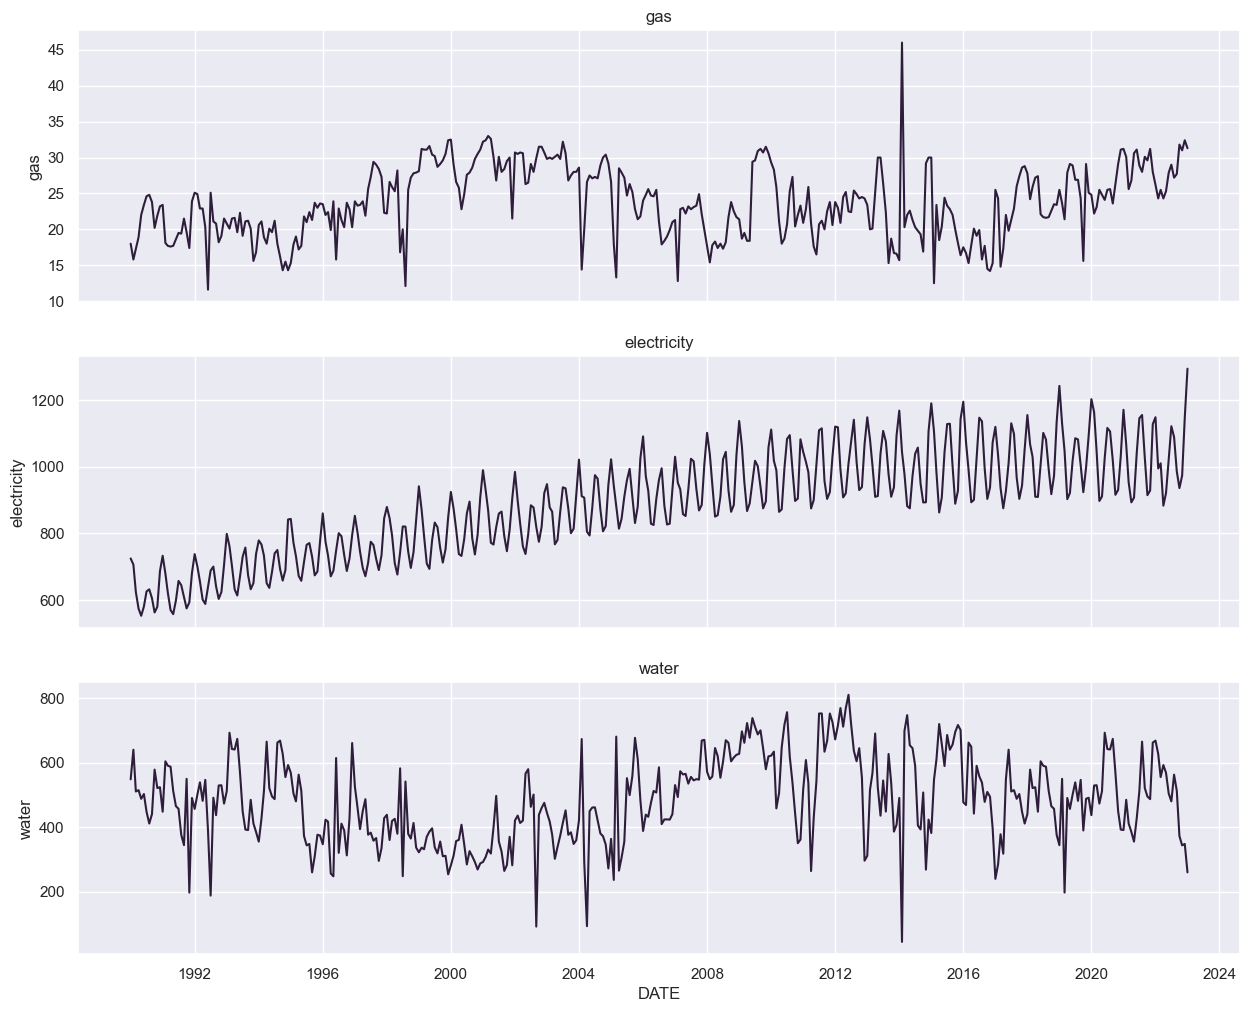

In [3]:
fig,ax = plt.subplots(3,1,figsize=(15,12),sharex=True)
for i,v in enumerate(df.columns):
    sns.lineplot(df[v],ax=ax[i])
    ax[i].set_title(v)
fig.show()

Gas:
- Very vague trend
- Data has a large outlier in 2013
- Random drops in the data

Electricity:
- Clear yearly seasonal trend
- Spikes in electricity in Dec/Jan and Jun/July 
- Variance seems to be increasing 

Water:
- Compared to electricity data, this one has more vague trends
- Data has a large drops randomly in the data

### Moving Average

To see the trends more clearly I will use a moving average.

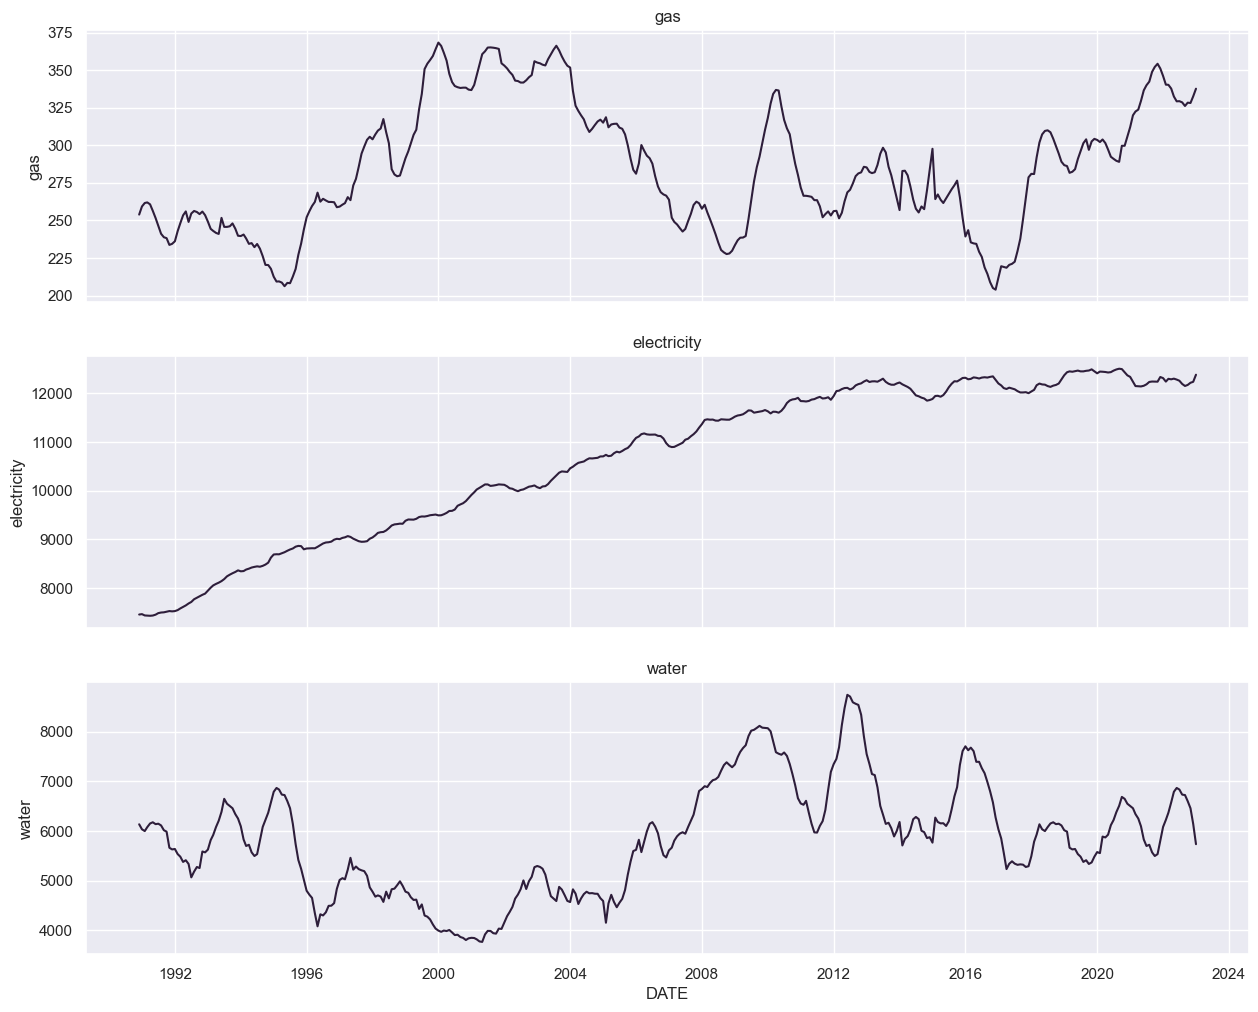

In [4]:
fig,ax = plt.subplots(3,1,figsize=(15,12),sharex=True)
for i,v in enumerate(df.columns):
    sns.lineplot(df[v].rolling(12).sum(),ax=ax[i])
    ax[i].set_title(v)
fig.show()

Gas:
- Overall there is no clear trend in data
- Large increase from 1996 to 2008 with smaller spikes later on
- Seem to have large cycles

Electricity:
- Clear upward trend
- Slight dips here and there 
- Plateau aftet 2012

Water:
- Overall there is no clear trend in data
- Some seasonal pattern appears with random spikes but it could be cycles too


### Decomposition

There are many methods of decomposition:
- Classical (naive approach)
- X11
- Seats
- STL

Among these, STL (Seasonal and Trend decomposition using Loess) is the most robust method:
- can handle changing seasonality
- robust to outliers (by specifying robust=True).

The only downside is that it only has a additive model by default, though a multiplicative one can be obtained by logging.

I will be using STL in this assignment

In [5]:
def customDecompose(data,stl,stl2,keyVals):
    fig,ax = plt.subplots(4,1,figsize=(14,8))
    sns.lineplot(data,ax=ax[0])
    trend = pd.concat([stl.trend,stl2.trend],axis=0,keys=keyVals).reset_index().rename(columns={"level_0":"Type"})
    sns.lineplot(data=trend,x="DATE",y="trend",hue="Type",ax=ax[1],palette= sns.color_palette("mako",n_colors=2))
    trend = pd.concat([stl.seasonal,stl2.seasonal],axis=0,keys=keyVals).reset_index().rename(columns={"level_0":"Type"})
    sns.lineplot(data=trend,x="DATE",y="season",hue="Type",ax=ax[2],palette= sns.color_palette("mako",n_colors=2))
    trend = pd.concat([stl.resid,stl2.resid],axis=0,keys=keyVals).reset_index().rename(columns={"level_0":"Type"})
    sns.lineplot(data=trend,x="DATE",y="resid",hue="Type",ax=ax[3],palette= sns.color_palette("mako",n_colors=2))
    plt.show()
def strengthTrendSeason(stl):
    print("Strength of Trend       :", max(0, (1-(np.var(stl.resid))/(np.var(stl.resid+stl.trend)))))
    print("Strength of Seasonality :", max(0, (1-(np.var(stl.resid))/(np.var(stl.resid+stl.seasonal)))))


#### Electricity

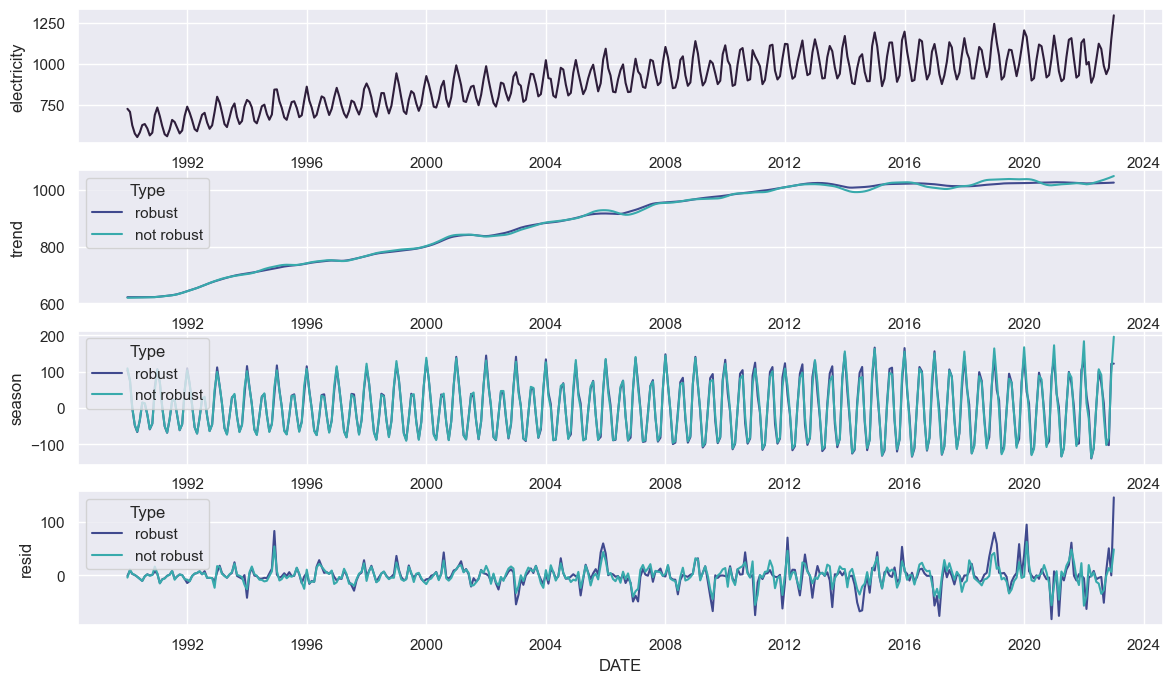

In [6]:
stl = STL(elec, robust=True).fit()
stl2 = STL(elec).fit()

customDecompose(elec,stl,stl2,["robust","not robust"])

Insights:
- Robust method handles outliers better -> doesn't let outliers impact the trend or seasoanlity
- Seasonality has increasing variance
- Variance of residuals low

To further my analysis, I will analyse the impact of trend and season on the data using the following formula given in the book Forecasting Principles and Practice. 

Strength of Trend:
$$F(T) = \max \left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(T_t + R_t)}\right)$$
Strength of Seasonal:
$$F(S) = \max \left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(S_t + R_t)}\right)$$

Interpretation: The higher the value, the stronger the impact

In [7]:
strengthTrendSeason(stl)

Strength of Trend       : 0.9726498161983994
Strength of Seasonality : 0.9187072380270594


Insights:
- This is a heavily trended and seasonal data from this results
- Both trend and season seem to have approximately the same effect.

For data like this, It will be much easier to forecast as the noise is pretty low. Seasonal models will work better here. 

#### Water

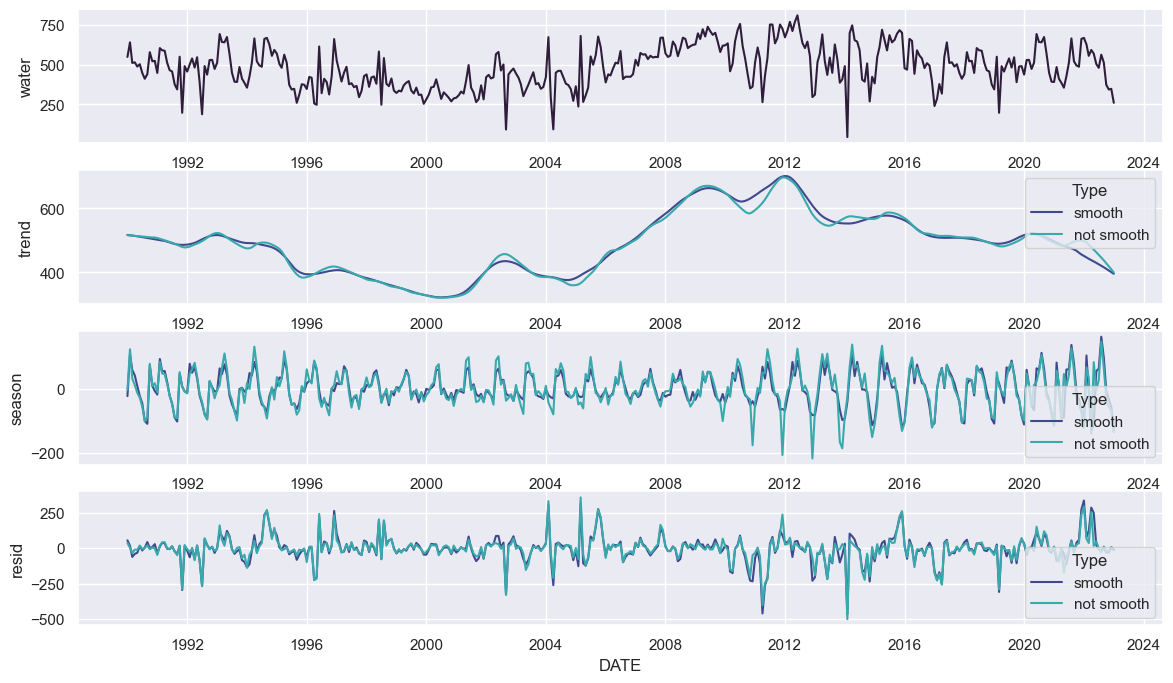

In [8]:
stl2 = STL(water, robust=True).fit()
stl = STL(water, robust=True,seasonal=11,trend=31).fit()
customDecompose(water,stl,stl2,["smooth","not smooth"])

Insights:
- Adding smoothing makes the trend more clear 
- Trend shows gradualy rise and decline
- Seasonal pattern pretty complex -> has long term cycles
- Residuals are pretty high

In [9]:
strengthTrendSeason(stl)

Strength of Trend       : 0.42683963928489144
Strength of Seasonality : 0.1437634628266422


Insights: 
- As expected seasonality is very weak
- Trend is moderately strong but again, data is quite noisy

Seasonal models will not do well for this data.

#### Gas

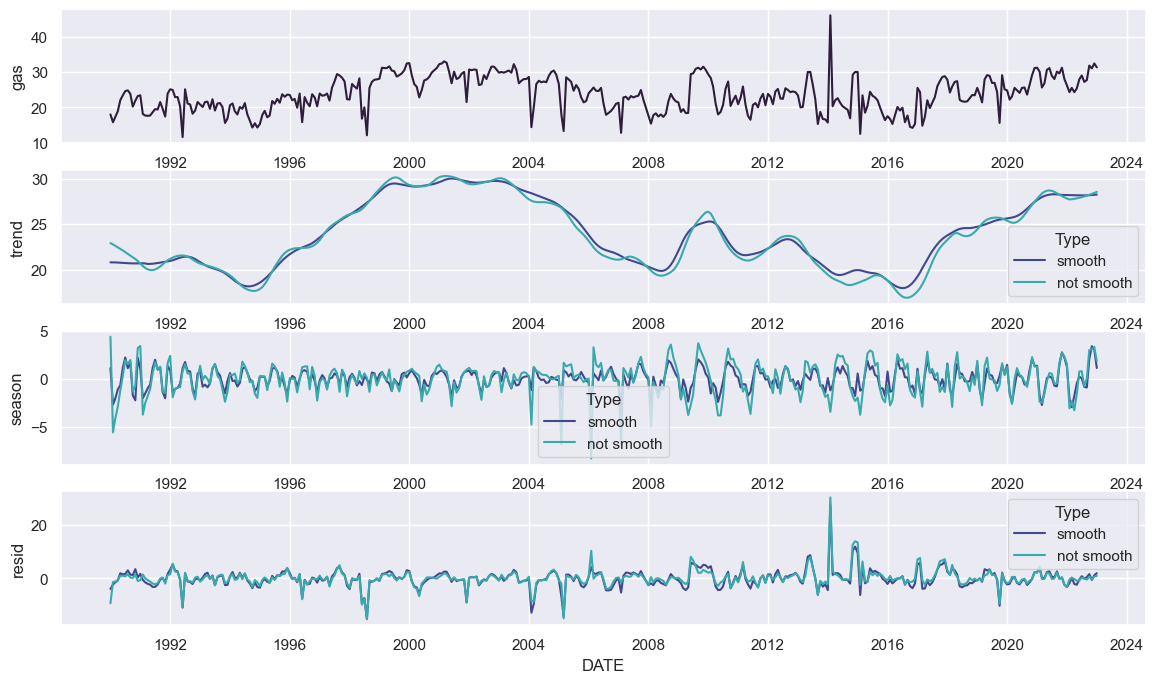

In [10]:
stl2 = STL(gas, robust=True).fit()
stl = STL(gas, robust=True,seasonal=11,trend=31).fit()

customDecompose(gas,stl,stl2,["smooth","not smooth"])

Insights:
- The trend shows a increase from 1995 to 2003 and followed by a decline
- There is a bump in 2009 and in 2013 followed by a increase after 2016
- There seem to be complex yearly seasonality with cycles too



In [11]:
strengthTrendSeason(stl)

Strength of Trend       : 0.5111574969405573
Strength of Seasonality : 0.09621025916514558


Insights: 
- Seasonality is very weak
- Trend is moderately strong but again, data is quite noisy

Won't need seasonal models for this

### EDA Summary

| Variable    | EDA Observations                                                  | Moving Average Observations                                    | Decomposition Observations                                | Strength of Trend and Season Observations        |
|-------------|--------------------------------------------------------------------|-----------------------------------------------------------------|---------------------------------------------------------|--------------------------------------------------|
| Gas         | - Vague trend<br>- Large outlier in 2013<br>- Random drops        | - No clear trend<br>- Increase 1996-2008<br>- Large cycles   | - Complex yearly seasonality with cycles                | - Weak seasonality<br>- Moderately strong trend  |
| Electricity | - Clear yearly seasonality<br>- Spikes in Dec/Jan and Jun/Jul     | - Clear upward trend<br>- Slight dips<br>- Plateau after 2012 | - Seasonality with increasing variance                | - Moderately strong season and trend            |
| Water       | - Vague trends<br>- Random drops                                  | - No clear trend<br>- Seasonal pattern<br>- Random spikes   | - Trend shows gradual rise and decline<br>- Complex cycles | - Very weak seasonality<br>- Moderately strong trend |



## Exponential Smoothing
Simple method than ARIMA. Predict using weighted linear sums of past observations where these weights decrease exponentially.

There are 3 main types of ExponentialSmoothing Statsmodels Offers:
- Simple Exponential Smoothing: Exactly how it sounds like pretty naive approach
- Holt's Exponential Smoothing: Simple Method that also considers the trend component
- Holt Winter's Exponential Smoothing: Considers both trend and seasonality

### Electricity

As observed in the EDA, due to high seasonal patterns I will be using Holt's Exponential Smoothing.
During EDA, we found a plateau after 2012, so I will try adding damped_trend=True here

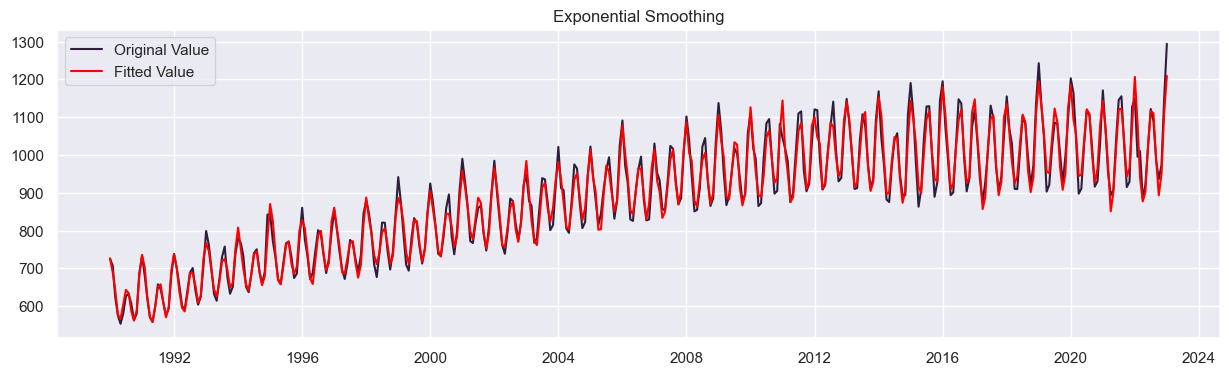

In [12]:
model = ExponentialSmoothing(elec, trend='add', seasonal='add', seasonal_periods=12,damped_trend=True).fit()
fittedvals = model.fittedvalues
plt.figure(figsize=(15, 4))
plt.plot(elec,label="Original Value")
plt.plot(fittedvals,label="Fitted Value",color="red")
plt.legend()
plt.title("Exponential Smoothing")
plt.show()

Insights:
- Model is well fit in general
- Only extreme values are not captured by model

### Gas

Due to weak seasonality, I don't think Holt's Winter will do well so I will use Holt's Exponential Smoothing instead.

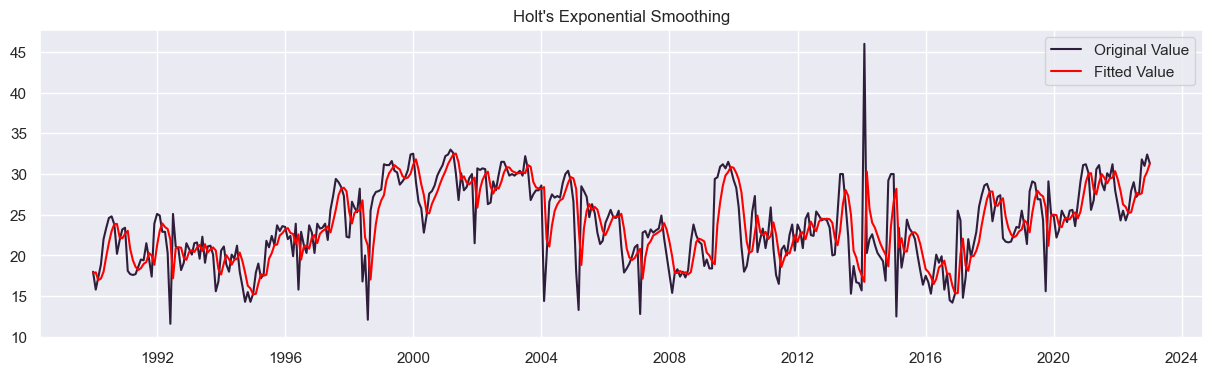

1022.7250080999502


In [13]:
model = Holt(gas).fit()
fittedvals = model.fittedvalues
plt.figure(figsize=(15, 4))
plt.plot(gas,label="Original Value")
plt.plot(fittedvals,label="Fitted Value",color="red")
plt.legend()
plt.title("Holt's Exponential Smoothing")
plt.show()
print(model.aic)

Insights:
- Data is fitted but seems to be misaligned
- Fitted Value doesn't capture extreme values
- Fitted value doesn't capture noise

Now, I will also try Simple Exponential Smoothing.

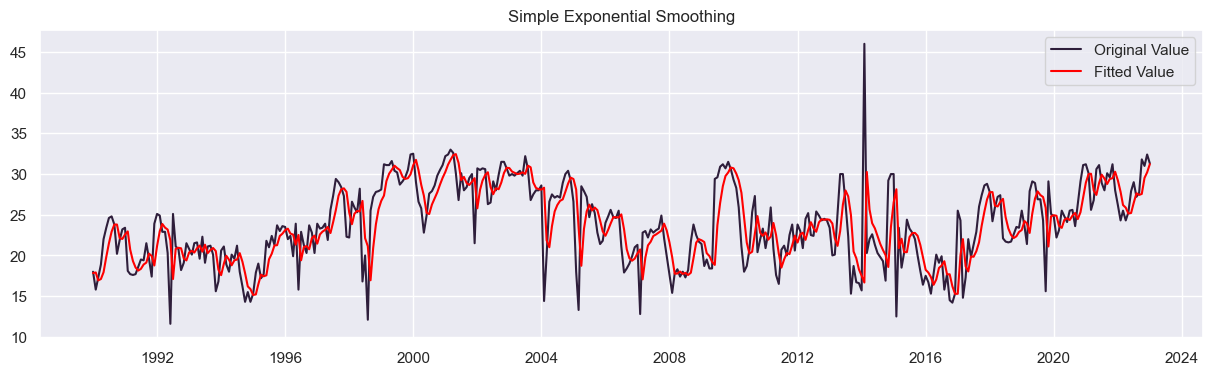

1018.8908671976302


In [14]:
model = SimpleExpSmoothing(gas).fit()
fittedvals = model.fittedvalues
plt.figure(figsize=(15, 4))
plt.plot(gas,label="Original Value")
plt.plot(fittedvals,label="Fitted Value",color="red")
plt.legend()
plt.title("Simple Exponential Smoothing")
plt.show()
print(model.aic)

Insights:
- Fitted data looks almost the same
- AIC is lower than before due to simpler model
- Extreme values were not captured

This Model seems good enough for this data.

### Water
Similiar to gas, due to weak seasonality, I will use Holt's Exponential Smoothing

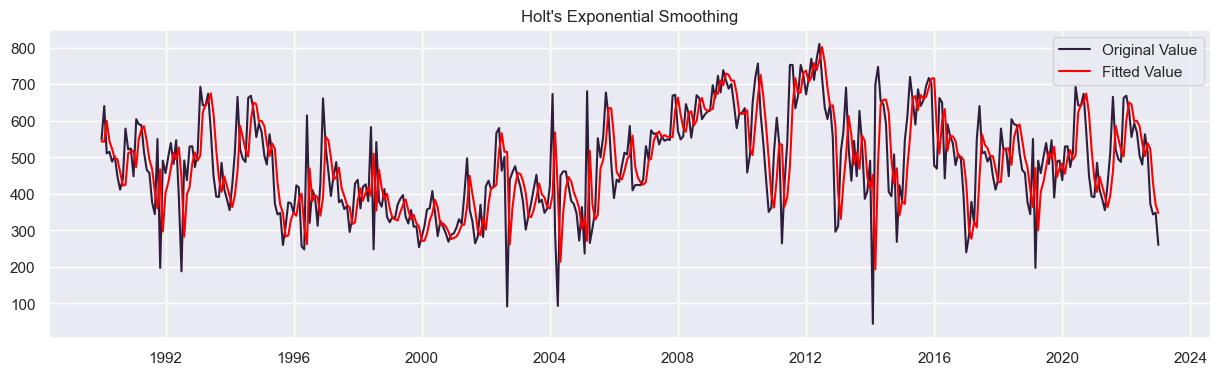

3727.3939269421517


In [15]:
model = Holt(water).fit()
fittedvals = model.fittedvalues
plt.figure(figsize=(15, 4))
plt.plot(water,label="Original Value")
plt.plot(fittedvals,label="Fitted Value",color="red")
plt.legend()
plt.title("Holt's Exponential Smoothing")
plt.show()
print(model.aic)

Insights:
- Similar to gas fitted values seem to be misaligned indicating difficulty in prediction
- Unnecessary noise present in fitted values.

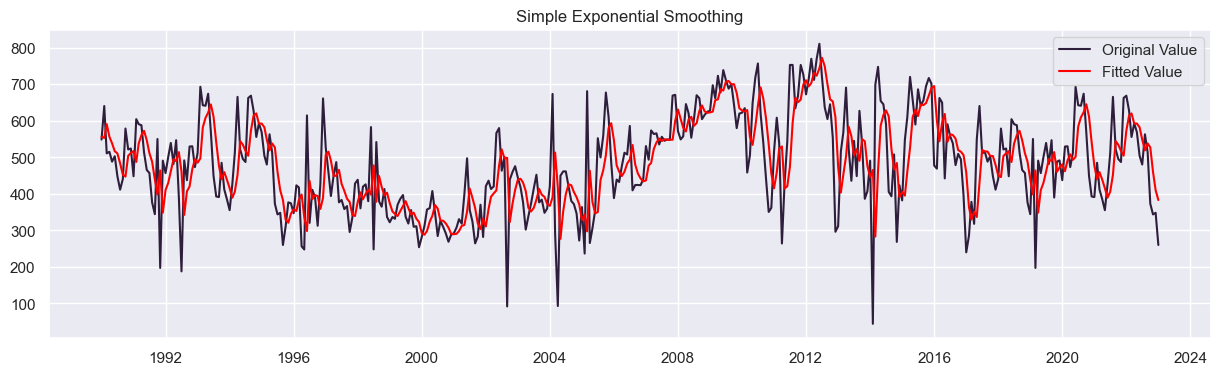

3696.2732149661038


In [16]:
model = SimpleExpSmoothing(water).fit()
fittedvals = model.fittedvalues
plt.figure(figsize=(15, 4))
plt.plot(water,label="Original Value")
plt.plot(fittedvals,label="Fitted Value",color="red")
plt.legend()
plt.title("Simple Exponential Smoothing")
plt.show()
print(model.aic)

Insights:
- AIC is slightly lower due to less complex model
- Graph seems well fit

I would keep this

### Scoring

When forecasting values using the model, we would like to know how accurate the forecast is. To do so, we can utilise a train test split to use the test accuracy as forecast accuracy.

Some methods of spliting data:
- Simple: Split data into fixed percentage and use just the recent data to evaluate
- Sliding Windows: Old training data is dropped as new ones are added. cross validation needed
- Expanding Window: Old data is kept as new ones are added. Cross validation needed

I find Expanding windows to be very robust and I will implement using SkLearn's TimeSeriesSplit function.

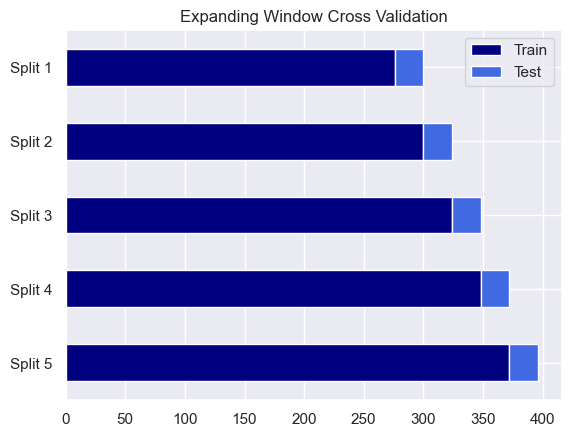

In [17]:
tscv = TimeSeriesSplit(n_splits=5, test_size=24)
arr = []
for i, (train_index, test_index) in enumerate(tscv.split(elec)):
    arr.append([train_index[-1],(test_index[-1]-train_index[-1])])
arr2 = pd.DataFrame(data=arr,columns=["Train","Test"],index=["Split 1","Split 2","Split 3","Split 4","Split 5"])
arr2 = arr2.iloc[::-1]
arr2.plot(kind='barh', stacked=True, color=['navy', 'royalblue'])
plt.title("Expanding Window Cross Validation")
plt.show()

When we do cross validation, we also need to decide on a metric to score the predicted values. 

For this there are:
- Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values.
- Mean Absolute Scaled Error (MASE): Measures the accuracy of forecasts relative to the mean absolute error of a naive forecast.
- R-squared (R²): Measures the proportion of variance in the dependent variable explained by the model.
- Mean Absolute Percentage Error (MAPE): Average percentage difference between predicted and actual values

For this data, I think it is easier to interpret MAPE aa the columns use different units.

In [18]:
def crossVal(df, test_splits, test_size, models,**kwargs):
    scores = []
    tscv = TimeSeriesSplit(n_splits=test_splits, test_size=test_size)
    for train_index, test_index in tscv.split(df):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]
        model_inst = models(train_data,**kwargs)
        model_fit = model_inst.fit()
        y_pred = model_fit.forecast(len(test_data))
        score = mean_absolute_percentage_error(test_data, y_pred)
        scores.append(score)
    return np.mean(scores)

Using this, let's score the models and predict for 2 years.

In [19]:
def plotForecast(df,forecast,name,mape):
    print("Cross Validation Score (MAPE):", mape)
    plt.figure(figsize=(15, 4))
    plt.plot(df, label='Original Data')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.title(name)
    plt.show()

Cross Validation Score (MAPE): 0.03634203851174535


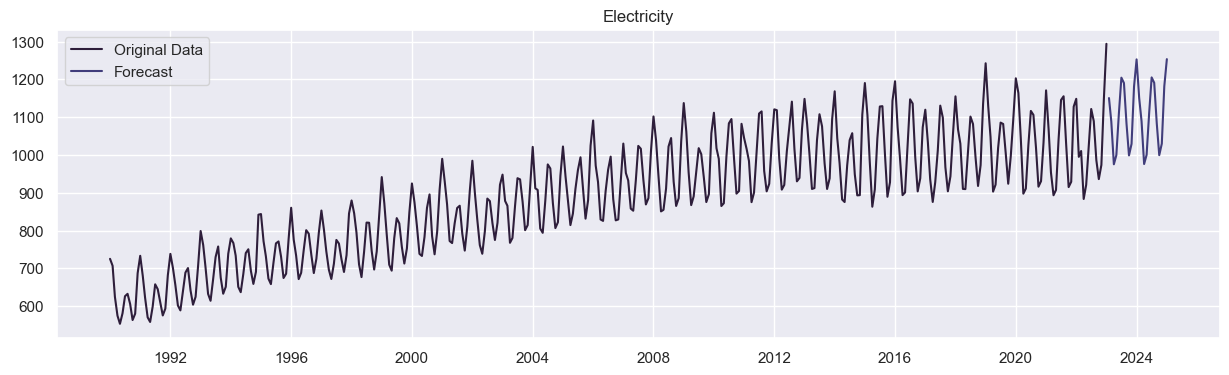

Cross Validation Score (MAPE): 0.30884402933910304


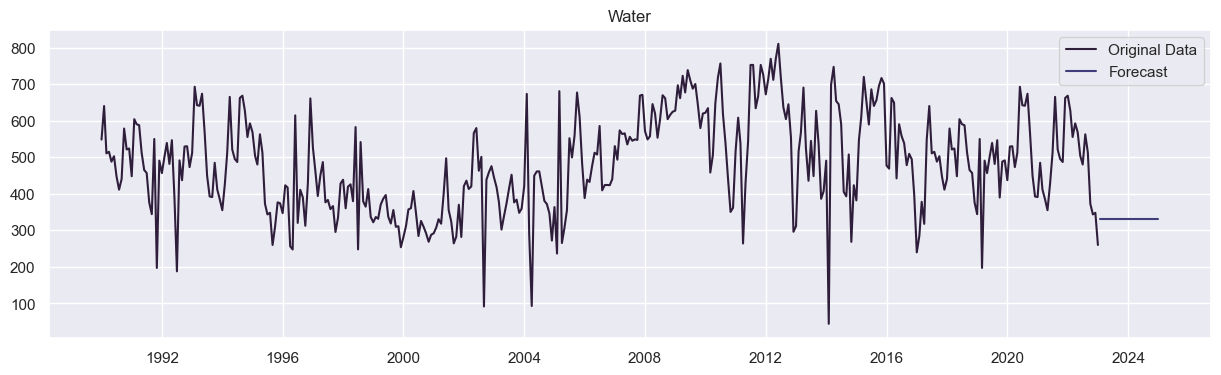

Cross Validation Score (MAPE): 0.23626889625014322


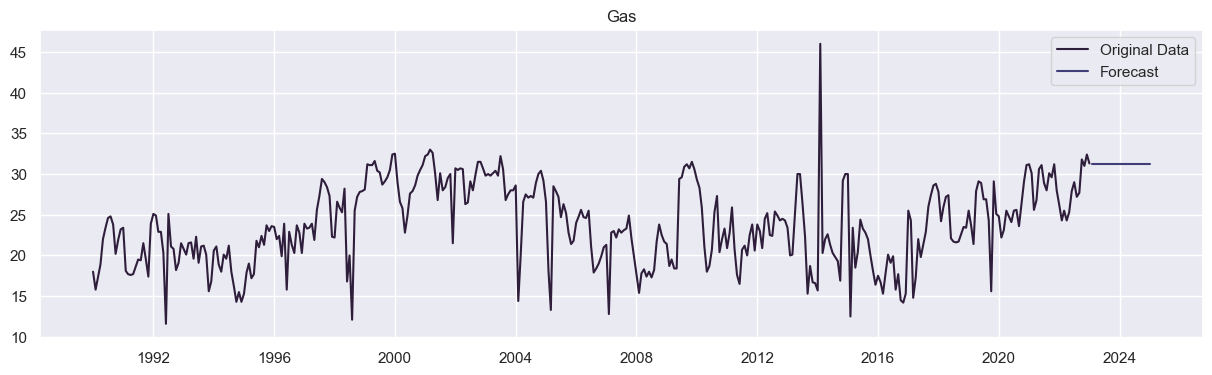

In [20]:
model = ExponentialSmoothing(elec, trend='add', seasonal='add', seasonal_periods=12,
                             damped_trend=True).fit()
forecast_values = model.forecast(steps=24)
mape_score = crossVal(elec,5,24,ExponentialSmoothing, 
                      trend='add', seasonal='add', seasonal_periods=12,
                      damped_trend=True)
plotForecast(elec,forecast_values,"Electricity",mape_score)

model =SimpleExpSmoothing(water).fit()
forecast_values = model.forecast(steps=24)
mape_score = crossVal(water,5,24,SimpleExpSmoothing)
plotForecast(water,forecast_values,"Water",mape_score)

model = SimpleExpSmoothing(gas).fit()
forecast_values = model.forecast(steps=24)
mape_score = crossVal(gas,5,24,SimpleExpSmoothing)
plotForecast(gas,forecast_values,"Gas",mape_score)

Electricity:
- Good MAPE of 3.6% meaning the model is 96.4% accurate
- Predicted data seems quite reasonable

Gas:
- Bad MAPE of 30.8% meaning model is only 69.2% accurate
- Predicts a straight line due to simple model

Water:
- Bad MAPE of 23.6% meaning model is only accurate 76.4%
- Predicts a straight line with no regard for trend

Due to strong trend and seasonality, electricity perform very well here. Due to the lack of it, gas and water didn't do well.

## ARIMA

ARIMA works on autocorrelation rather than trend or seasonality. ARIMA is a combination of Autoregression (AR) and Moving Average (MA) with possibility to difference data.

$$
Y_t = \mu + \sum_{k=1}^{p} \varphi_k (Y_{t-k} - \mu) + \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
$$

ARIMA is regression model and as a result, it works best when its predictors are not correlated. For this, we ensure that the data is stationary.

Stationary means data:
- has contant mean
- has constant variance
- has no seasonality

To assess this, I will use the ADF (Augmented Dickey Fuller) test. It has the following hypotheses:
- H0: Series not stationary
- H1: Series stationary

I will also analyse the ACf plot of the data as it can indicate stationarity.

In [21]:
def stationarityPlots(data,name):
    fig,ax = plt.subplots(1,2,figsize=(16,5))
    data.plot(ax=ax[0])
    ax[0].set_title(name)
    plot_acf(data,ax=ax[1])
    print(f"P-value for ADF Test ({name}): ", adfuller(data)[1])
    fig.show()

#### Electricity

P-value for ADF Test (Electricity):  0.1862180230033656


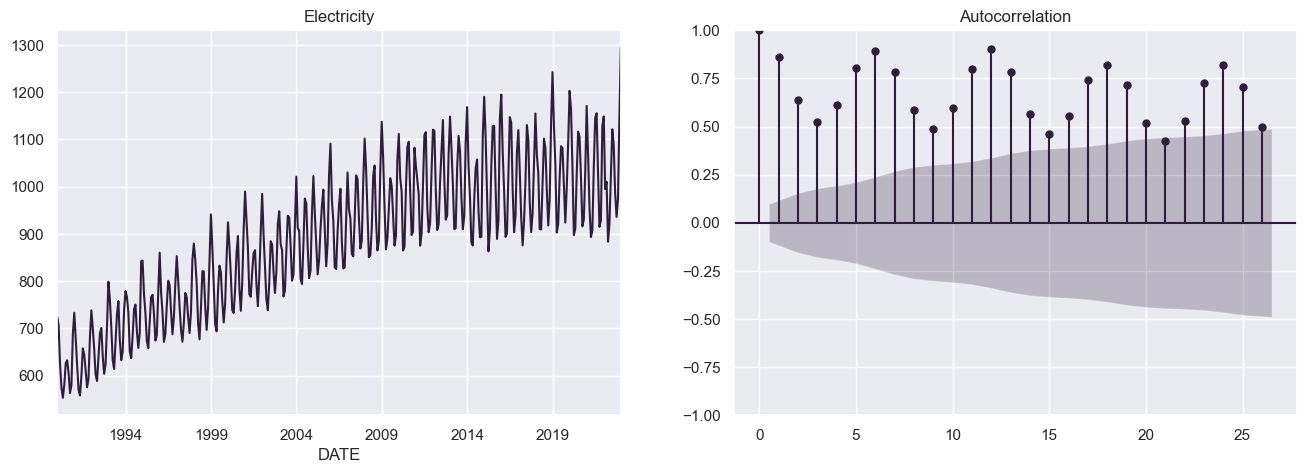

In [22]:
stationarityPlots(elec,"Electricity")

Insights:
1. Electricity Plot
    - Increasing trend
    - Increasing variance
2. ACF Plot
    - Lags never enter the colored zone in the plot due to trend
    - Seasonal patterns at every 6th spike
3. ADF Test
    - P-value > 0.05 => series not stationary.

Solutions:

1. Trend & Seasonality => Seasonal Differencing
2. Changing Variance => Box-Cox Transformation

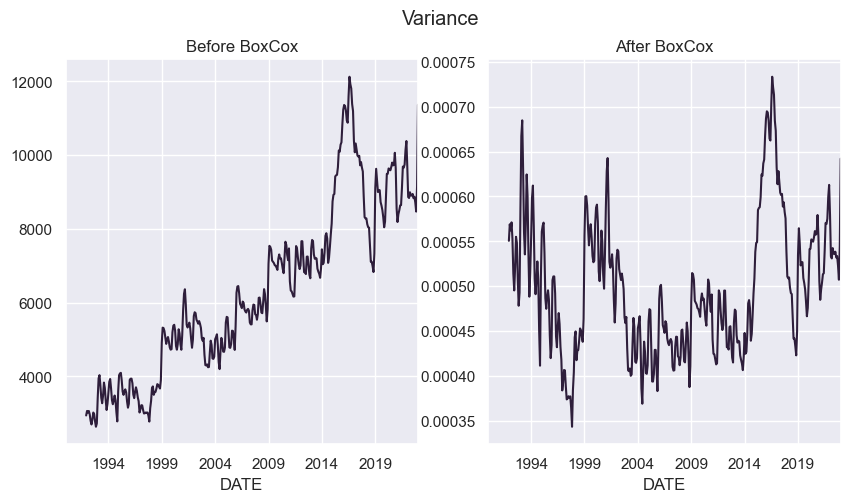

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
cox_elec = boxcox(elec,lmbda=-0.2)
cox_elec = pd.Series(data = cox_elec,index = elec.index)
elec.rolling(24).var().plot(ax=ax[0])
ax[0].set_title("Before BoxCox")
cox_elec.rolling(24).var().plot(ax=ax[1])
ax[1].set_title("After BoxCox")
fig.suptitle("Variance")
fig.show()

P-value for ADF Test (Electricity):  1.5628803778216277e-05


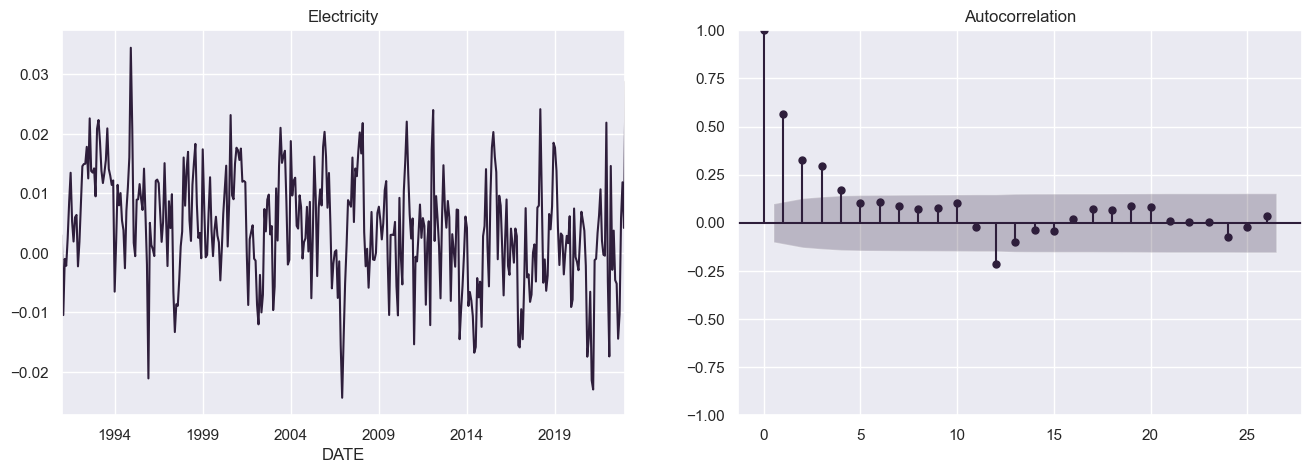

In [24]:
stationarityPlots(cox_elec.diff(12)[12:],"Electricity")

Insights:
- Mean = 0
- Variance => Normal
- ACF normal
- ADF p-value < 0.05 => data is stationary

Since seasonal differencing is need, SARIMA will be used to set D = 1

#### Gas

P-value for ADF Test (Gas):  0.010810651707060331


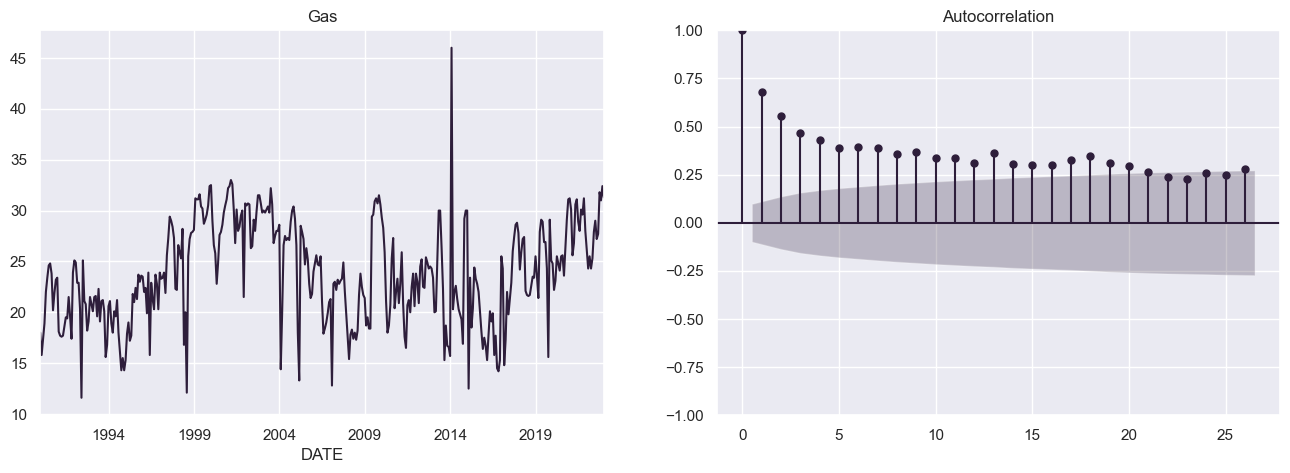

In [25]:
stationarityPlots(gas,"Gas")

Insights:
1. Gas Plot
    - No overall trend but increasing trend for last 25 vals
    - Variance normal
2. ACF Plot
    - 20 positive significant lags => more differencing needed
    - No seasonal pattern
3. ADF Test
    - P-value < 0.05 => series is stationary.

To remove trend differencing might be needed.

P-value for ADF Test (Gas):  6.396189162972846e-12


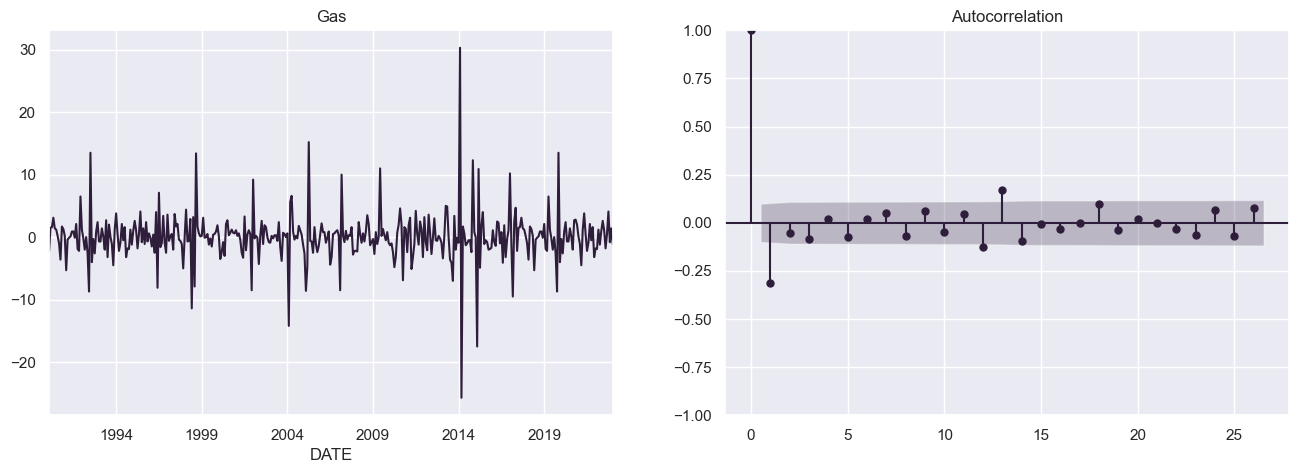

In [26]:
stationarityPlots(gas.diff()[1:],"Gas")

Insights:
- Mean = 0
- Variance should be fine
- Few large outliers
- ACF find

Due to lack of seasonality, SARIMA might not be needed.

#### Water

P-value for ADF Test (Water):  8.984549388336955e-05


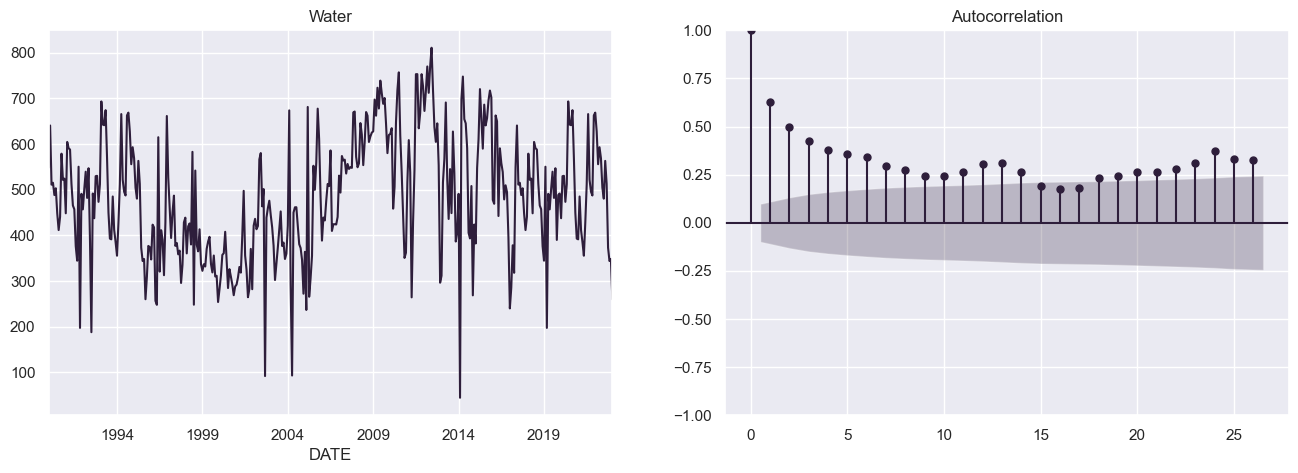

In [27]:
stationarityPlots(water,"Water")

Insights:
1. Water Plot
    - Large cycles and some trend
    - Stable variance
2. ACF Plot
    - High number of positive significant lags
    - Some seasonality every 12th lag
3. ADF Test
    - P-value < 0.05 => series is stationary

Normal differencing should be enough but seasonal differencing in possible.

P-value for ADF Test (After Diff):  4.3354157508677254e-15


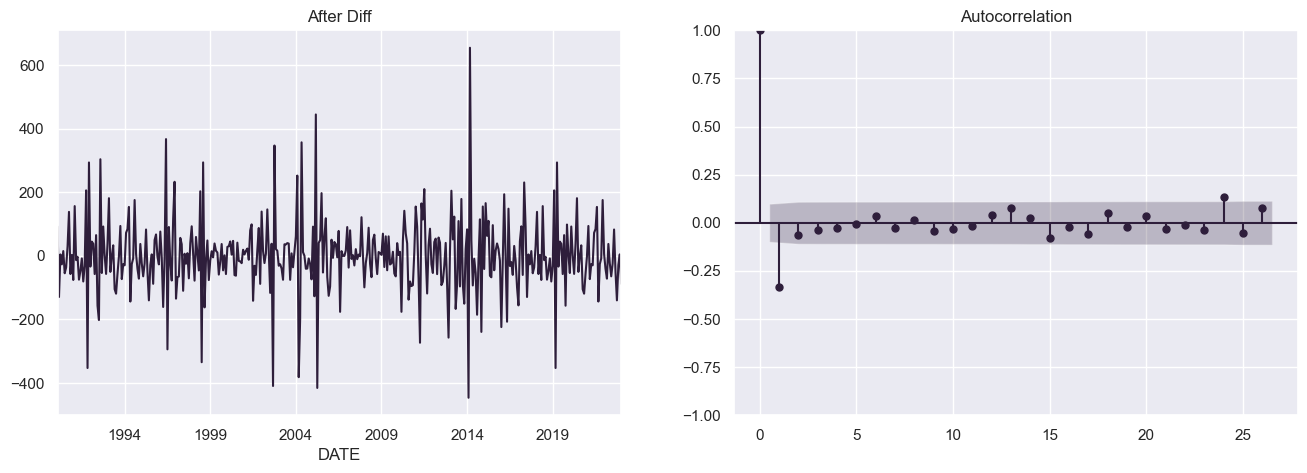

In [28]:
stationarityPlots(water.diff()[1:],"After Diff")

P-value for ADF Test (After Diff):  3.975385202267819e-10


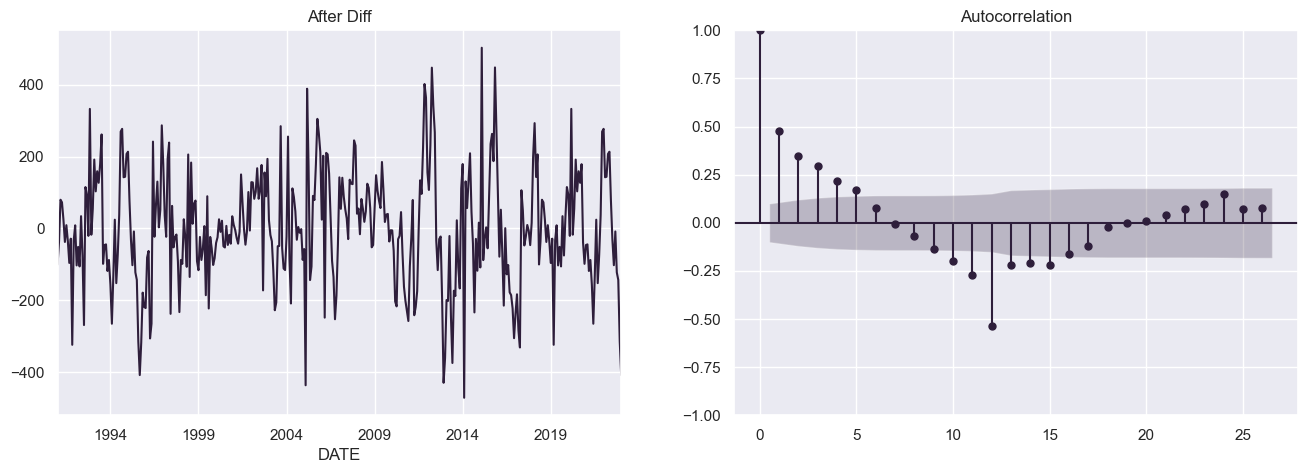

In [29]:
stationarityPlots(water.diff(12)[12:],"After Diff")

Normal differencing seems to be better.

- Mean = 0
- Variance fine
- Not much seasonality

I don't think SARIMA will be suitable for this data, ARIMA will be fine.

#### Summary

- Electricity => Box-Cox Transform => Seasonal Differencing 
- Gas => Differencing
- Water => Differencing

In [30]:
def acfPacf(data):
    fig,ax = plt.subplots(1,2,figsize=(14,5))
    plot_acf(data,ax=ax[0])
    plot_pacf(data,ax=ax[1])
    ax[0].set_title("ACF Plot")
    ax[1].set_title("PACF Plot")
    fig.show()

### Modelling

Now I will try to find the best ARIMA/SARIMA models for the data.

I will be using the box-jenkins Method to do this.

![box jenkins](https://www.researchgate.net/publication/284516167/figure/fig1/AS:302515112431616@1449136631471/The-Box-Jenkins-methodology.png)

#### Electricity

Based on observations, SARIMA will be the best model for this.

![eqn](https://miro.medium.com/v2/resize:fit:1400/1*0A5Y8uQlGcVe6QpOGonZpw.png)

We need to use the ACF/PACF plots 

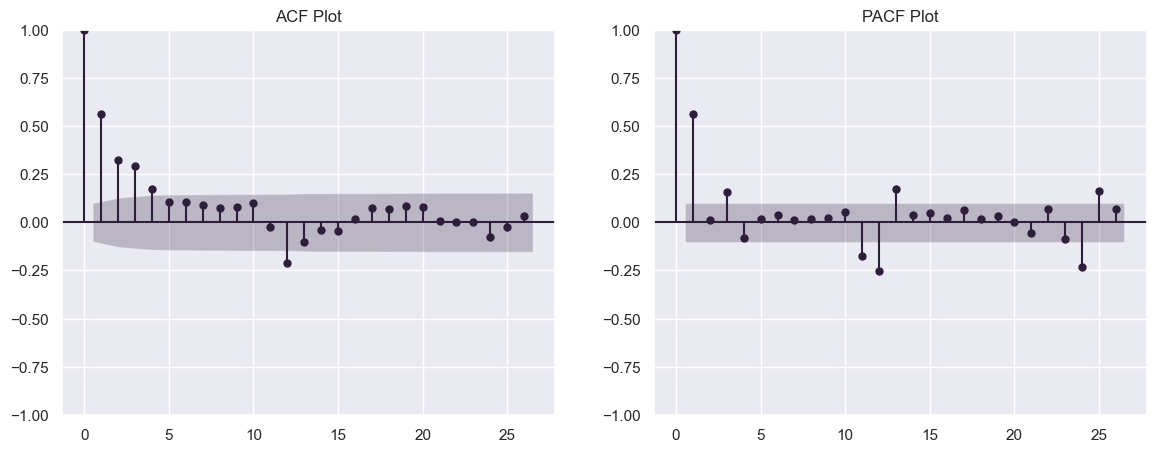

In [31]:
acfPacf(cox_elec.diff(12)[12:])


| Process      | Requirement                                             | Plot Name                    | Lag Selection                 | Chosen Value |
|--------------|---------------------------------------------------------|------------------------------|-------------------------------|--------------|
| AR           | Specify \( p \) terms for future value prediction      | PACF Plot                    | Lag 1 drops to 0              | 1            |
| MA           | Specify \( q \) terms for autocorrelation removal      | ACF Plot                     | Lags 1-5                      | 5            |
| Seasonal AR  | Specify \( P \) terms for seasonal prediction          | PACF Plot                    | Lags 12, 24                   | 2            |
| Seasonal MA  | Specify \( Q \) terms for seasonal autocorrelation removal     | ACF Plot                     | Lag 12                        | 1            |

Order = (1, 0, 5) x (2, 1, 1, 12)


In [32]:
arima = ARIMA(endog=cox_elec,order=(1,0,5),seasonal_order=(2,1,1,12)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  397
Model:             ARIMA(1, 0, 5)x(2, 1, [1], 12)   Log Likelihood                1387.646
Date:                            Fri, 11 Aug 2023   AIC                          -2755.291
Time:                                    20:18:49   BIC                          -2715.759
Sample:                                01-01-1990   HQIC                         -2739.613
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9528      0.022     43.933      0.000       0.910       0.995
ma.L1         -0.2810      0.059     -4.784      0.000      -0.396      -0.166
ma.L2         -0.2012      0.055     -3.657      0.000      -0.309      -0.093
ma.L3          0.0386      0.059      0.656      0.512      -0.077       0.154
ma.L4         -0.0622      0.059     -1.047      0.295      -0.178       0.054
ma.L5         -0.0440      0.055     -0.798      0.425      -0.152       0.064
ar.S.L12      -0.2103      0.098     -2.151      0.031      -0.402      -0.019
ar.S.L24      -0.3431      0.073     -4.680      0.000      -0.487      -0.199
ma.S.L12      -0.4010      0.105     -3.830      0.000      -0.606      -0.196
sigma2      4.234e-05   3.14e-06     13.474      0.000    3.62e-05    4.85e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 2.88
Prob(Q):                              0.49   Prob(JB):                         0.24
Heteroskedasticity (H):               1.35   Skew:                            -0.14
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
def loopOrder(df,p,d,q,P,D,Q,m):
    param_arrays = [p,d,q,P,D,Q,m]
    param_combinations = list(itertools.product(*param_arrays))
    results = {"AIC":[],"BIC":[],"CrossVal":[], "FittedMape":[],"Ljung":[],"ResidMean":[]}
    print(f"Total {len(param_combinations) } Combinations")
    for i in param_combinations:
        arima = ARIMA(endog=df,order=i[0:3],seasonal_order= i[3:]).fit()
        mape_score = crossVal(df,3,24,ARIMA,order=i[0:3],seasonal_order= i[3:])
        results["BIC"].append(arima.bic)
        results["AIC"].append(arima.aic)
        results["FittedMape"].append(mean_absolute_percentage_error(df[12:],arima.fittedvalues[12:]))
        results["CrossVal"].append(mape_score)
        results["Ljung"].append(arima.test_serial_correlation(method="ljungbox")[0][1][0])
        results["ResidMean"].append(arima.resid.mean())
        print(0,end="-")
    results = pd.DataFrame(data=results,index=param_combinations)
    return results.sort_values(by="CrossVal",ascending=True)

In [34]:
resElec = loopOrder(cox_elec,[1,3],[0],[3,4],[0,1],[1],[1],[12])
resElec

Total 8 Combinations
0-0-0-0-0-0-0-0-

AIC          BIC  CrossVal  FittedMape  \
(3, 0, 4, 0, 1, 1, 12) -2771.516054 -2735.936864  0.001840    0.001369   
(1, 0, 3, 0, 1, 1, 12) -2752.829196 -2729.109736  0.001844    0.001415   
(3, 0, 4, 1, 1, 1, 12) -2777.866083 -2738.333650  0.001892    0.001372   
(1, 0, 4, 0, 1, 1, 12) -2746.845845 -2719.173141  0.001928    0.001430   
(1, 0, 4, 1, 1, 1, 12) -2748.406901 -2716.780954  0.001931    0.001421   
(1, 0, 3, 1, 1, 1, 12) -2759.399633 -2731.726930  0.001949    0.001401   
(3, 0, 3, 0, 1, 1, 12) -2760.872226 -2729.246280  0.002112    0.001387   
(3, 0, 3, 1, 1, 1, 12) -2759.911280 -2724.332090  0.002188    0.001401   

                           Ljung  ResidMean  
(3, 0, 4, 0, 1, 1, 12)  0.976669   0.110203  
(1, 0, 3, 0, 1, 1, 12)  0.206473   0.110770  
(3, 0, 4, 1, 1, 1, 12)  0.457373   0.109502  
(1, 0, 4, 0, 1, 1, 12)  0.996612   0.110899  
(1, 0, 4, 1, 1, 1, 12)  0.067735   0.110848  
(1, 0, 3, 1, 1, 1, 12)  0.579953   0.110670  
(3, 0, 3, 0, 1, 1, 12)  0.966940   0.110320  
(3, 0, 3, 1, 1, 1, 12)  0.167591   0.109972

Insights:
- Best Cross Validation Score will be 0.18% for the order (3,0,4)x(0,1,1,12)
- It has the highest Ljung Box which means the residuals have no autocorrelation meaning all the information in the data has been captured by model
- Resid mean not high so its fine
- AIC,BIC and FittedMAPE around the same

In [35]:
arima = ARIMA(endog=cox_elec,order=(3,0,4),seasonal_order=(0,1,1,12)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  397
Model:             ARIMA(3, 0, 4)x(0, 1, [1], 12)   Log Likelihood                1394.758
Date:                            Fri, 11 Aug 2023   AIC                          -2771.516
Time:                                    20:19:46   BIC                          -2735.937
Sample:                                01-01-1990   HQIC                         -2757.405
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5841      0.614      0.951      0.341      -0.619       1.787
ar.L2         -0.1442      0.546     -0.264      0.792      -1.214       0.926
ar.L3          0.5371      0.505      1.063      0.288      -0.453       1.527
ma.L1          0.0601      0.610      0.098      0.922      -1.136       1.256
ma.L2          0.1697      0.428      0.396      0.692      -0.670       1.009
ma.L3         -0.2407      0.285     -0.845      0.398      -0.799       0.318
ma.L4         -0.1851      0.115     -1.612      0.107      -0.410       0.040
ma.S.L12      -0.8484      0.036    -23.880      0.000      -0.918      -0.779
sigma2      4.039e-05   2.62e-06     15.395      0.000    3.52e-05    4.55e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.51
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               1.38   Skew:                            -0.21
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Insights:
- AIC around the same
- Jarque Bera worsened

To see if its a problem, I will look at the residuals.

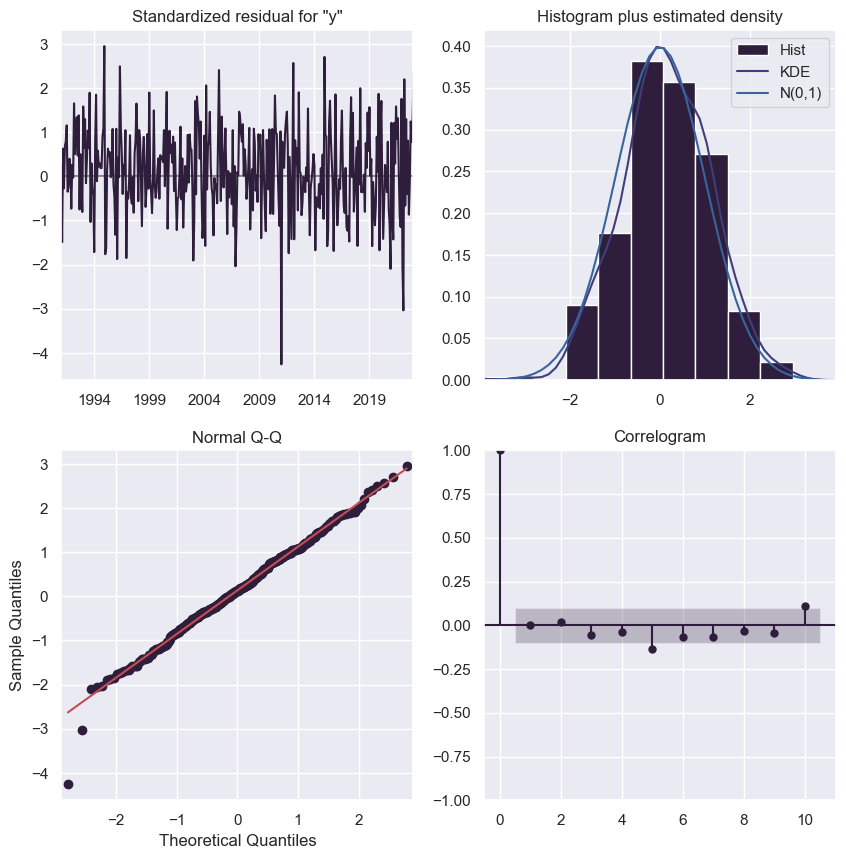

In [36]:
arima = ARIMA(endog=cox_elec,order=(3,0,4),seasonal_order=(0,1,1,12)).fit()
arima.plot_diagnostics(figsize=(10,10))
plt.show()

Residuals dont show any real trend and the distribution is close to normal.

Best model for Electricity is SARIMA(3,0,4)x(0,1,1,12)

#### Gas

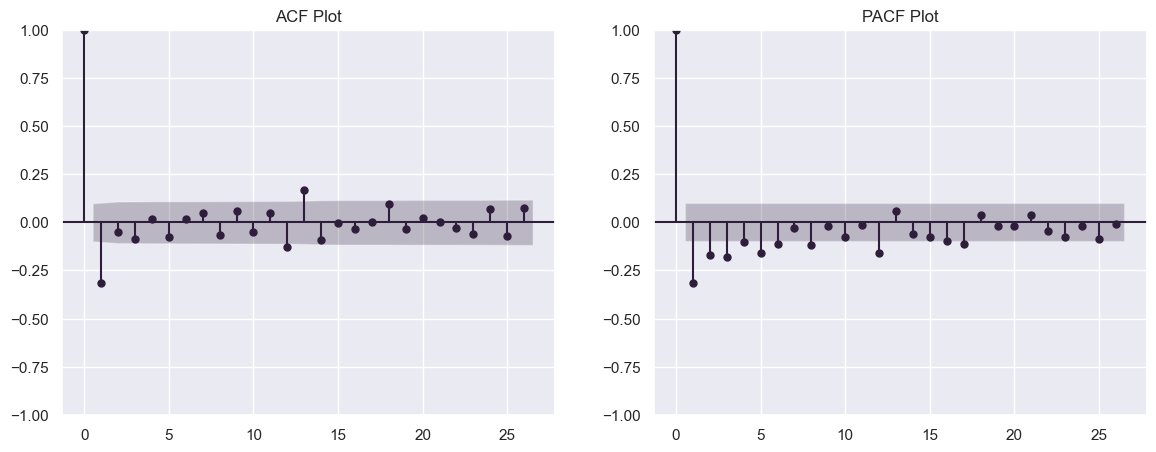

In [37]:
acfPacf(gas.diff()[1:])

| Process      | Requirement                                             | Plot Name                    | Lag Selection                 | Chosen Value |
|--------------|---------------------------------------------------------|------------------------------|-------------------------------|--------------|
| AR           | Specify \( p \) terms for future value prediction      | PACF Plot                    | Lag 1,2,3 and then drops to 0              | 3            |
| MA           | Specify \( q \) terms for autocorrelation removal      | ACF Plot                     | Lag at 1                      | 1            |


Order = (3, 1, 1)

In [38]:
arima = ARIMA(endog=gas,order=(3,1,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gas   No. Observations:                  397
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1053.500
Date:                Fri, 11 Aug 2023   AIC                           2116.999
Time:                        20:19:49   BIC                           2136.907
Sample:                    01-01-1990   HQIC                          2124.886
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4176      0.047      8.972      0.000       0.326       0.509
ar.L2          0.0690      0.055      1.248      0.212      -0.039       0.177
ar.L3         -0.0330      0.070     -0.471      0.637      -0.170       0.104
ma.L1         -0.9046      0.041    -22.324      0.000      -0.984      -0.825
sigma2        11.9487      0.470     25.433      0.000      11.028      12.870
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2290.08
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Insights:
- AR term 2 and 3 are not significant
- Ljung-Box shows that residuals has not autocorrelation
- Jarque Bera shows data not normal

I will try different values and compare

In [39]:
resGas = loopOrder(gas,[1,2,3,4,5],[1],[1],[0],[0],[0],[0])
resGas

Total 5 Combinations
0-0-0-0-0-

AIC          BIC  CrossVal  FittedMape  \
(2, 1, 1, 0, 0, 0, 0)  2115.368708  2131.294365  0.134360    0.106496   
(1, 1, 1, 0, 0, 0, 0)  2114.604521  2126.548764  0.134810    0.106587   
(3, 1, 1, 0, 0, 0, 0)  2116.999485  2136.906556  0.135955    0.106957   
(4, 1, 1, 0, 0, 0, 0)  2118.896176  2142.784661  0.136584    0.107057   
(5, 1, 1, 0, 0, 0, 0)  2120.148599  2148.018499  0.137870    0.106825   

                          Ljung  ResidMean  
(2, 1, 1, 0, 0, 0, 0)  0.979923   0.192746  
(1, 1, 1, 0, 0, 0, 0)  0.617896   0.189224  
(3, 1, 1, 0, 0, 0, 0)  0.961326   0.190716  
(4, 1, 1, 0, 0, 0, 0)  0.964270   0.191857  
(5, 1, 1, 0, 0, 0, 0)  0.980852   0.188757

Insights:
- Best model is (2, 1, 1)
- All the columns roughly the same except for Ljung Box test which shows better result 



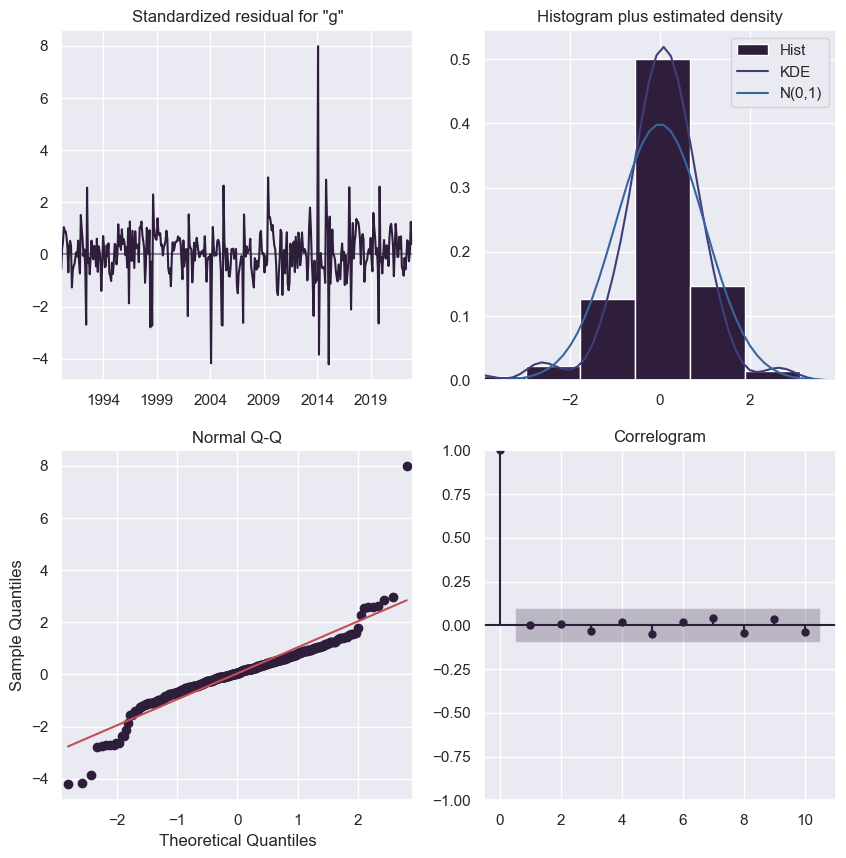

In [40]:
arima = ARIMA(endog=gas,order=(2,1,1)).fit()
arima.plot_diagnostics(figsize=(10,10))
plt.show()

The non-normal distribution of residuals is mostly due to extreme outliers present in the data. Otherwise the model fits well to the data.

Final Order (1,1,1)

#### Water

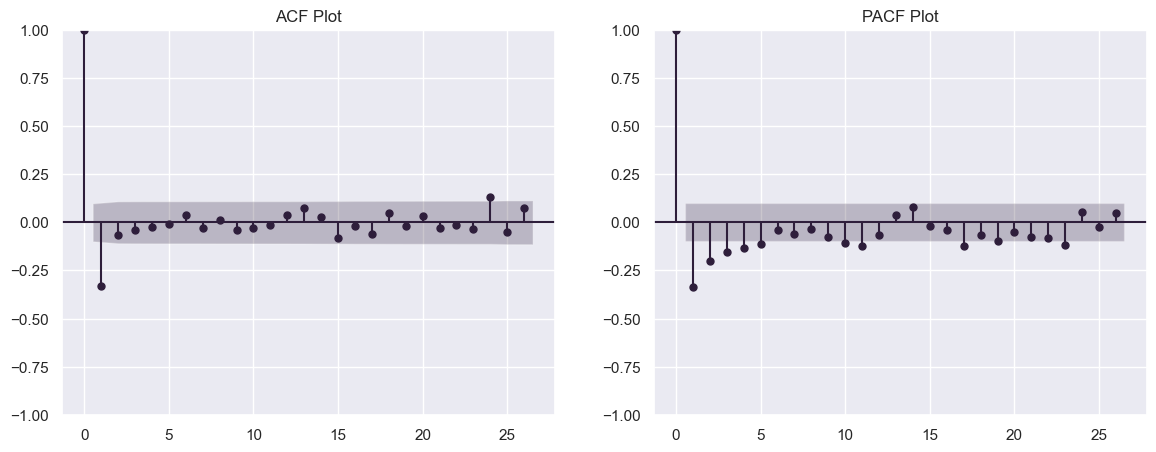

In [41]:
acfPacf(water.diff()[1:])

| Process      | Requirement                                             | Plot Name                    | Lag Selection                 | Chosen Value |
|--------------|---------------------------------------------------------|------------------------------|-------------------------------|--------------|
| AR           | Specify \( p \) terms for future value prediction      | PACF Plot                    | Lag 1,2,3,4 and then drops to 0              | 4            |
| MA           | Specify \( q \) terms for autocorrelation removal      | ACF Plot                     | Lag at 1                      | 1            |


Order = (4, 1, 1)

In [42]:
arima = ARIMA(endog=water,order=(4,1,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  water   No. Observations:                  397
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2389.985
Date:                Fri, 11 Aug 2023   AIC                           4791.970
Time:                        20:19:52   BIC                           4815.859
Sample:                    01-01-1990   HQIC                          4801.434
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4204      0.045      9.421      0.000       0.333       0.508
ar.L2          0.0814      0.055      1.469      0.142      -0.027       0.190
ar.L3          0.0198      0.061      0.324      0.746      -0.100       0.140
ar.L4          0.0137      0.057      0.243      0.808      -0.097       0.125
ma.L1         -0.9463      0.029    -32.286      0.000      -1.004      -0.889
sigma2       1.02e+04    521.381     19.559      0.000    9175.857    1.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               111.32
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                            -0.28
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Insights:
- AR 2nd 3rd and 3th term not significant
- Ljung-Box shows no autocorrelation among variables
- Jarque Bera shows data not normal

I will try different values

In [43]:
resWater = loopOrder(water,[1,2,3,4,5],[1],[1],[0],[0],[0],[0])
resWater

Total 5 Combinations
0-0-0-0-0-

AIC          BIC  CrossVal  FittedMape  \
(3, 1, 1, 0, 0, 0, 0)  4790.038117  4809.945188  0.177722    0.211339   
(2, 1, 1, 0, 0, 0, 0)  4788.248728  4804.174385  0.177977    0.211248   
(4, 1, 1, 0, 0, 0, 0)  4791.970215  4815.858700  0.178105    0.211439   
(5, 1, 1, 0, 0, 0, 0)  4793.832780  4821.702679  0.178470    0.210954   
(1, 1, 1, 0, 0, 0, 0)  4789.013214  4800.957456  0.180165    0.210984   

                          Ljung  ResidMean  
(3, 1, 1, 0, 0, 0, 0)  0.971728   0.096278  
(2, 1, 1, 0, 0, 0, 0)  0.945726   0.105948  
(4, 1, 1, 0, 0, 0, 0)  0.972590   0.087209  
(5, 1, 1, 0, 0, 0, 0)  0.971891   0.077287  
(1, 1, 1, 0, 0, 0, 0)  0.473393   0.117379

Insights:
- Best model is (3, 1, 1)
- All the columns roughly the same except for Ljung Box test which shows better result 


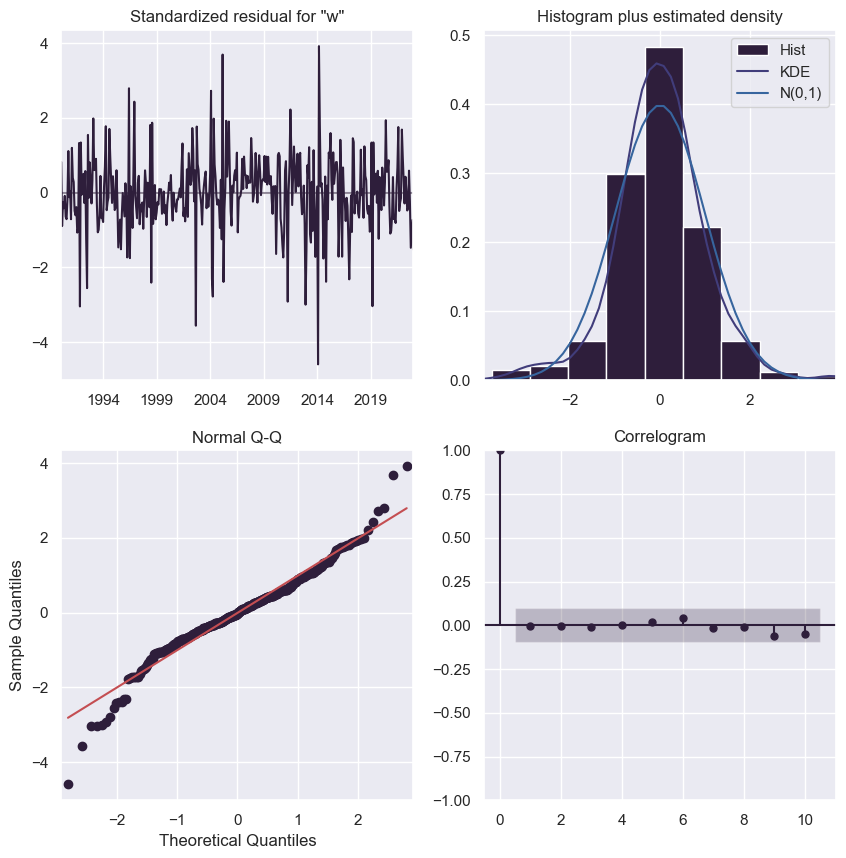

In [44]:
arima = ARIMA(endog=water,order=(3,1,1)).fit()
arima.plot_diagnostics(figsize=(10,10))
plt.show()

Again the non-normality is due to large outliers. For this data, the best order is (1,1,1)

#### Final Models

Cross Validation Score (MAPE): 0.0018177519217791559


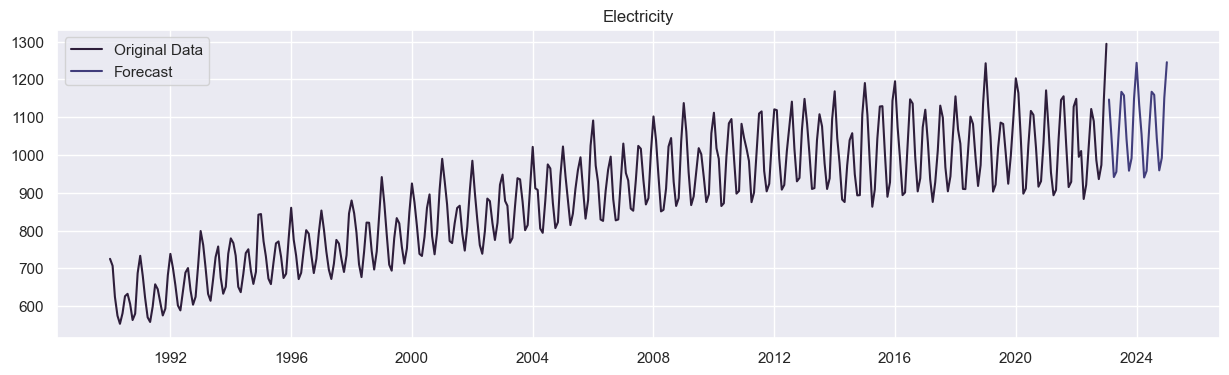

Cross Validation Score (MAPE): 0.3012950214290972


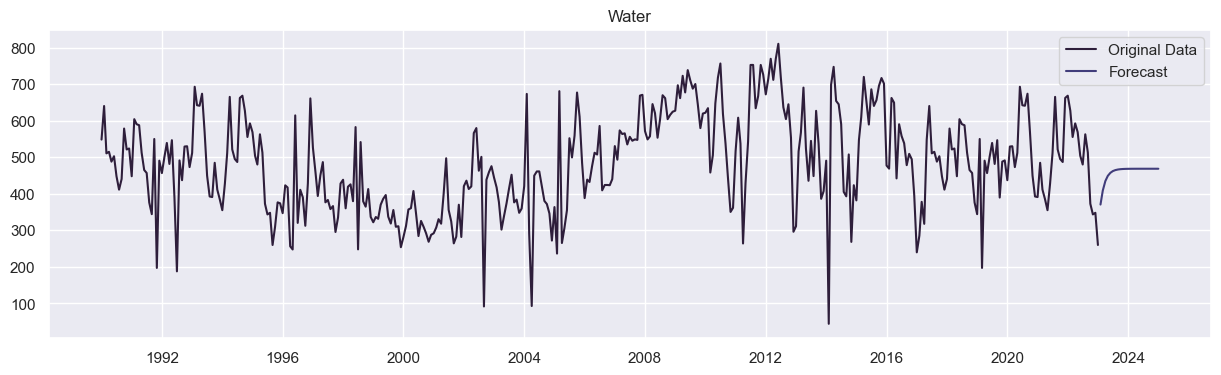

Cross Validation Score (MAPE): 0.19642508350825438


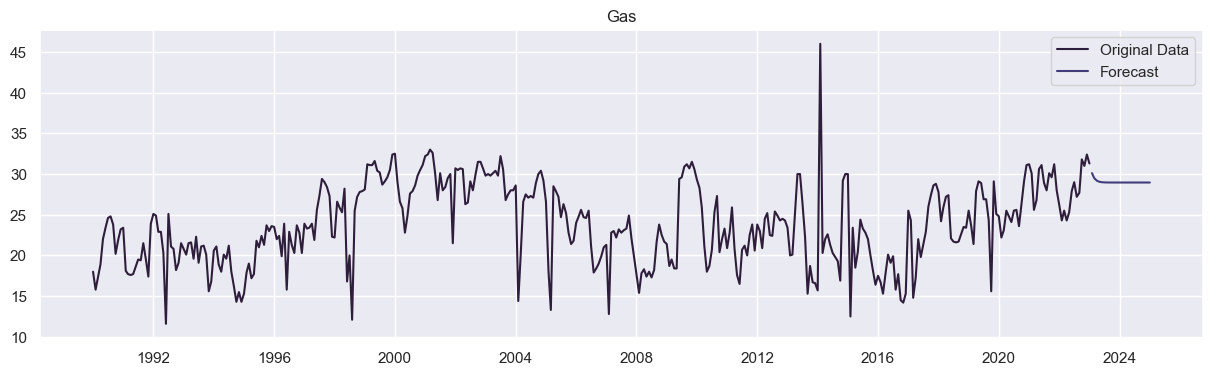

In [45]:
model = ARIMA(cox_elec,order=(3,0,4),seasonal_order=(0,1,1,12)).fit()
forecast_values = model.forecast(steps=24)
adjusted_forecast = pd.Series(data=inv_boxcox(forecast_values,-0.2),index=forecast_values.index) 
mape_score = crossVal(cox_elec,5,24,ARIMA,order=(3,0,4),seasonal_order=(0,1,1,12))
plotForecast(elec,adjusted_forecast,"Electricity",mape_score)

model =ARIMA(endog=water,order=(2,1,1)).fit()
forecast_values = model.forecast(steps=24)
mape_score = crossVal(water,5,24,ARIMA,order=(2,1,1))
plotForecast(water,forecast_values,"Water",mape_score)

model =  ARIMA(endog=gas,order=(3,1,1)).fit()
forecast_values = model.forecast(steps=24)
mape_score = crossVal(gas,5,24,ARIMA,order=(3,1,1))
plotForecast(gas,forecast_values,"Gas",mape_score)

Electricity:
- Amazing MAPE of 0.18% meaning the model is 99.82% accurate
- Graph looks pretty believable

Water:
- MAPE is pretty much same as Exponential Smoothing
- Line looks pretty ok compared to exponential smoothing

Gas:
- MAPE improved slightly to 19.6% which means model is 81.4% Accurate
- Line looks better than Exponential Smoothing

Overall, ARIMA greatly improved Electricity and slightly improve the rest. For gas and water, I might need to find other methods.

## Multivariate Models

I also have the option of using multiple variables to predict the future. This can be done for multivariate time series. For this there are 2 methods offered by Statsmodels:
- VARMAX (Vector Autoregressive Moving Average with eXogenous regressors): For stationary series
- VECM (Vector Error Correction Mechanism (VECM)): For non-stationary series whose linear combination is stationary (cointegrated)

To decide which method to use I will follow the suggestions of an article by Spur Economics.

| Cointegrating vectors or rank (r) | Trace Statistic                                           | Maximum eigenvalue statistic                       | Meaning               | Stationarity of variables                            | Model to be used       | Results                                                                                                            |
|-----------------------------------|------------------------------------------------------------|---------------------------------------------------|-----------------------|-----------------------------------------------------|------------------------|--------------------------------------------------------------------------------------------------------------------|
| 0                                 | H0: no cointegration and, HA: at least 1 cointegrating vector  | H0: no cointegration and, HA: 1 cointegrating vector  | No cointegration      | The variables are non-stationary and there are no long-run relationships among them | Apply VAR in differences | The VAR results show short-run coefficients                                                                       |
| 1                                 | H0: 1 cointegrating vector and, HA: at least 2 cointegrating vectors | H0: 1 cointegrating vector and, HA: 2 cointegrating vectors | Cointegration exists | The variables are non-stationary and the number of cointegrating relationships is equal to “r” | Apply VECM              | The VECM results show short-run coefficients and long-run equilibrium/cointegration relationship                |
| 2                                 | No need to test further because rank = 2 if above H0 is rejected for rank <= 1 | No need to test further because rank = 2 if above H0 is rejected for rank = 1 | No cointegration      | The variables are stationary and cointegration cannot exist in stationary variables     | Apply VAR to variables in their original form | The VAR results show long-run coefficients because the variables are not in differences |



(Rehal, 2023)

In [46]:
johan = coint_johansen(df,-1,1)
print("                              Johansen Test")
print("============================================================================")
print("Cointegration Rank\tMaximum Eigenvalue Statistic\tCritical Value at 5%")
for  i in range(0,3):
    print(str(i)+"\t\t\t"+str(johan.max_eig_stat[i])+"\t\t"+str(johan.max_eig_stat_crit_vals[i,1]))

                              Johansen Test
Cointegration Rank	Maximum Eigenvalue Statistic	Critical Value at 5%
0			90.05218492339944		17.7961
1			40.83517559334099		11.2246
2			0.20345790906409522		4.1296


Both rank 0 & 1 are in critical region but choosing higher rank is best practice.

Since rank=1, we can conclude VECM is more suitable than VAR for this data.

### Choosing Params

<Axes: xlabel='DATE'>

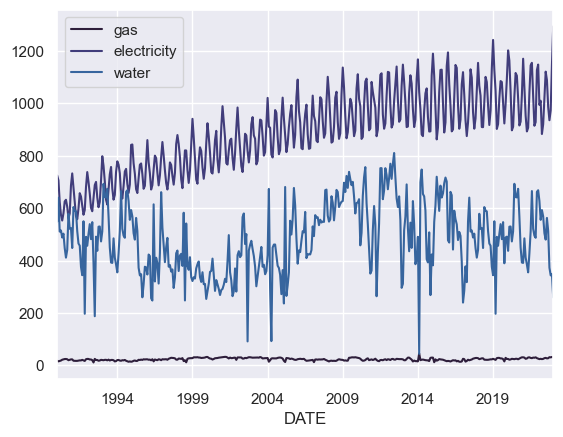

In [47]:
df.plot()

There seems to be a constant trend inside the cointegrating relationship here. Therefore I will set deterministic to "ci"

In [48]:
order = select_order(df,maxlags=10,deterministic="ci",seasons=12)
order.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

Lag 5 minimised AIC, so we will set k_ar_diff to 5

### Model

In [49]:
def varCrossVal(df, test_splits, test_size):
    scores = []
    tscv = TimeSeriesSplit(n_splits=test_splits, test_size=test_size)
    for train_index, test_index in tscv.split(df["gas"]):
        train_data = df.iloc[train_index,:]
        test_data = df.iloc[test_index,:]
        model_inst = VECM(train_data,deterministic="ci",seasons=12,k_ar_diff=5,coint_rank=1)
        model_fit = model_inst.fit()
        y_pred = model_fit.predict(steps=len(test_data))
        subScore = []
        for i in range(0,3):
            subScore.append(mean_absolute_percentage_error(test_data.values[:,i], y_pred[:,i]))
        scores.append(subScore)
    return np.mean(scores,axis=0)

gas MAPE: 0.21564820029387163
electricity MAPE: 0.03247408845311884
water MAPE: 0.29591867729663857


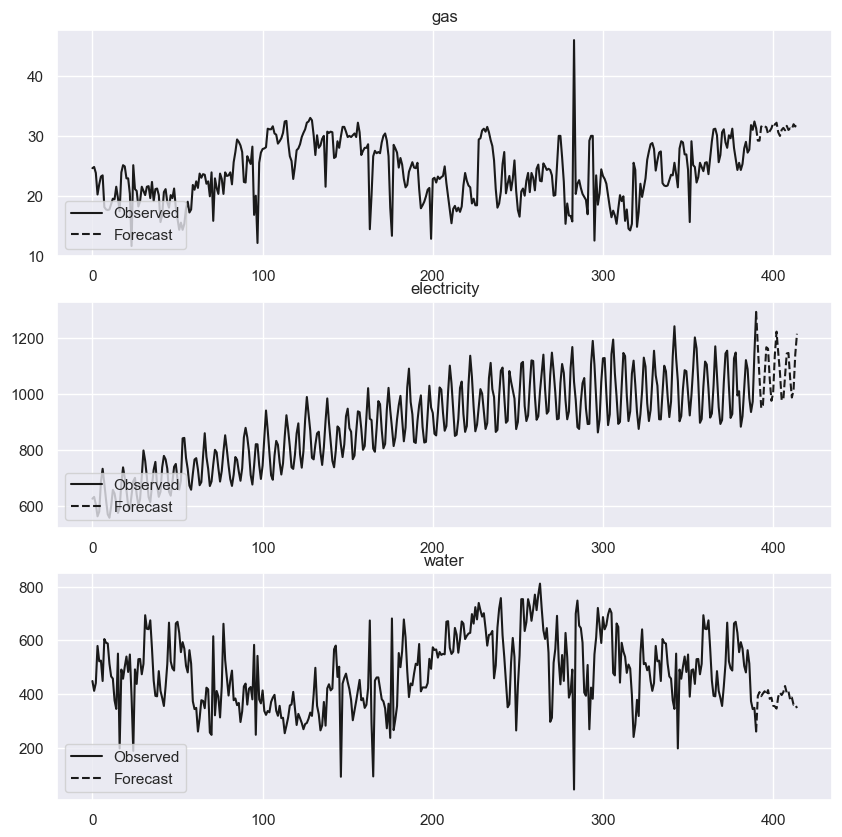

In [50]:
model = VECM(df,deterministic="ci",seasons=12,k_ar_diff=5,coint_rank=1).fit()
acc = varCrossVal(df,5,24)
for i in range(0,3):
    print(df.columns[i]+" MAPE: "+str(acc[i]))
model.plot_forecast(steps=24,plot_conf_int=False)

Overall, the MAPE seems to have decreased from ARIMA models. Only water improves but by only 1% which is not enough. 

## Model Improvement

Since ARIMA, Exponential Smoothing and VECM have not been able to forecast Gas and Water accurately, I will try to work around the problem.

The Problem:
- Data is noisy
- Trend and seasonality blurred due to noise
- Large outliers messing up the data

The Solution:
1. Use Loess Smoothing to smooth the data
2. Fit model on smooth data and predict
3. Plot and score original data against forecasts on smooth data

### Smoothing

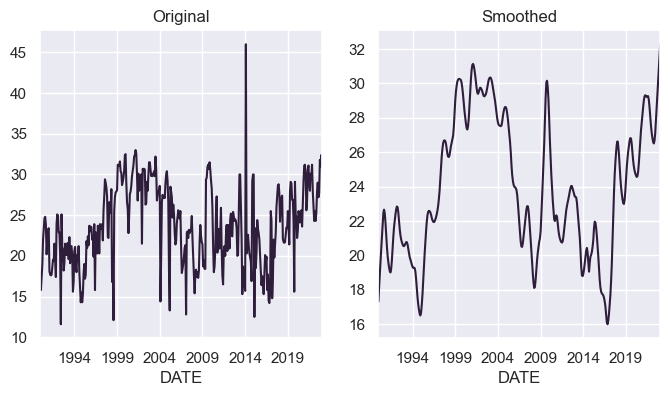

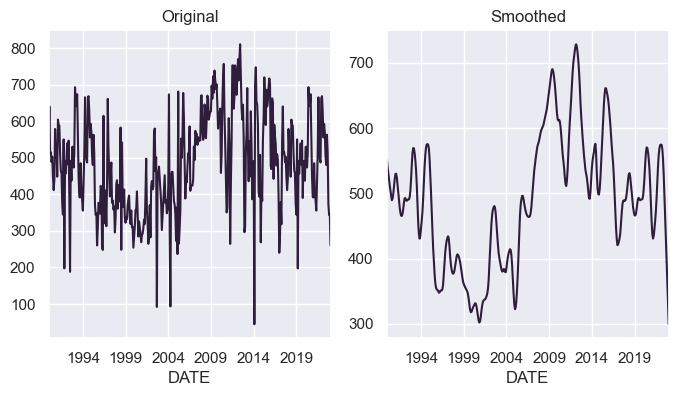

In [51]:
smoothGas = lowess(gas.values,gas.index,frac=0.04)
smoothGas = pd.Series(index=gas.index,data=smoothGas[:,1])

fig,ax = plt.subplots(1,2,figsize=(8,4))
gas.plot(ax=ax[0])
ax[0].set_title("Original")
smoothGas.plot(ax=ax[1])
ax[1].set_title("Smoothed")
fig.show()

smoothWater = lowess(water.values,water.index,frac=0.04)
smoothWater = pd.Series(index=water.index,data=smoothWater[:,1])

fig,ax = plt.subplots(1,2,figsize=(8,4))
water.plot(ax=ax[0])
ax[0].set_title("Original")
smoothWater.plot(ax=ax[1])
ax[1].set_title("Smoothed")
fig.show()

Insights:
- Outliers are gone
- Noise is reduced
- Data still has the same characteristics of the originals

### Stationarity

P-value for ADF Test (Smooth Gas):  0.5859094164778909
P-value for ADF Test (Smooth Water):  0.5272522251619742


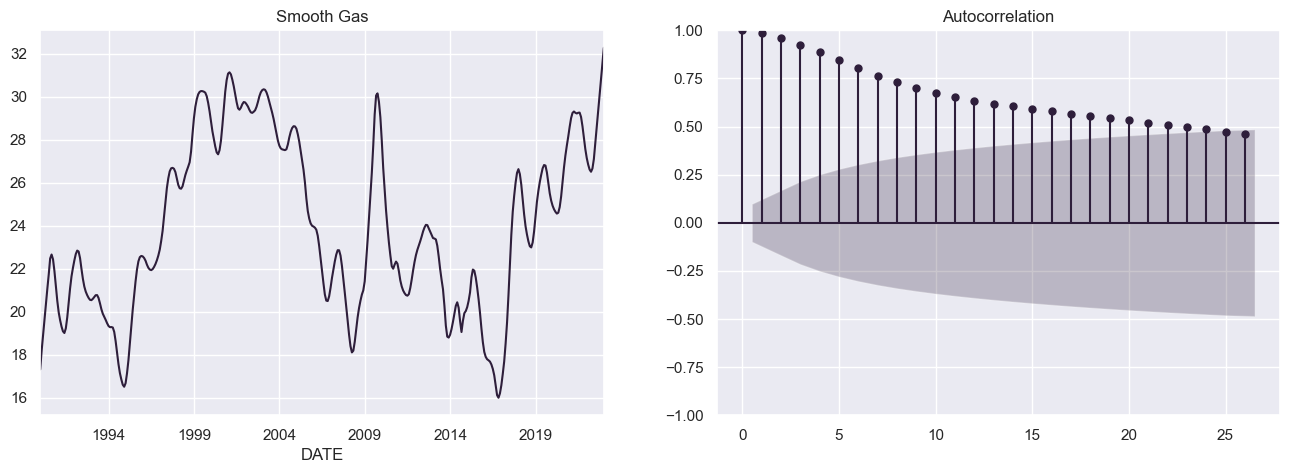

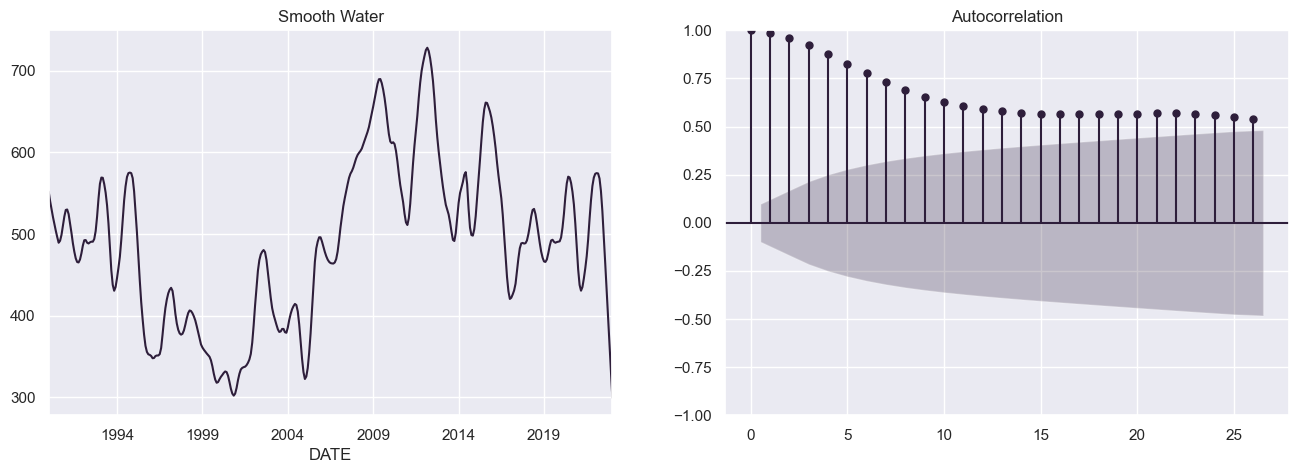

In [52]:
stationarityPlots(smoothGas,"Smooth Gas")
stationarityPlots(smoothWater,"Smooth Water")

I will perform differencing once here for both.

P-value for ADF Test (Diff Smooth Gas):  0.000558585547949733
P-value for ADF Test (Diff Smooth Water):  0.002640987938450551


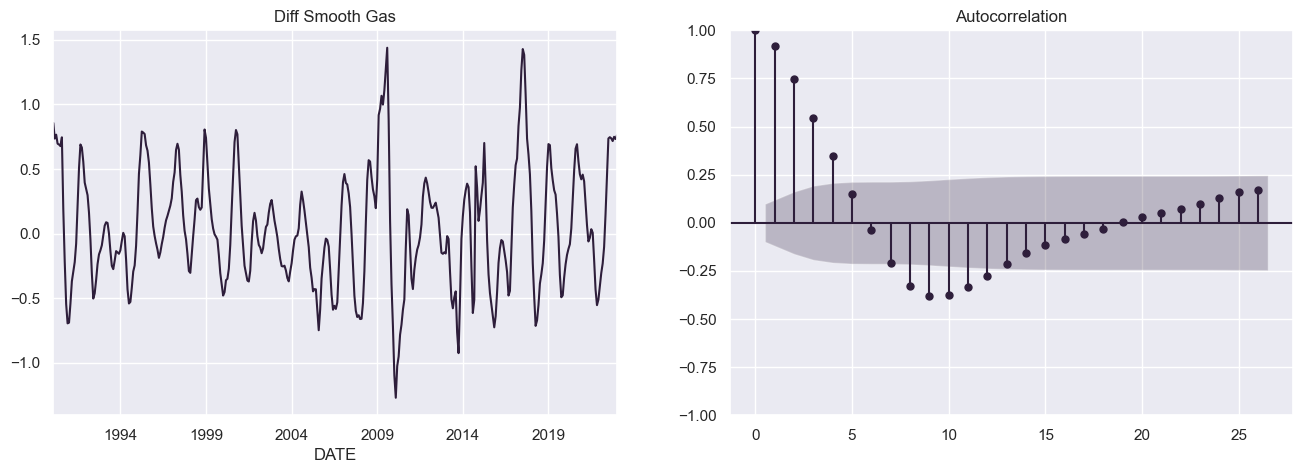

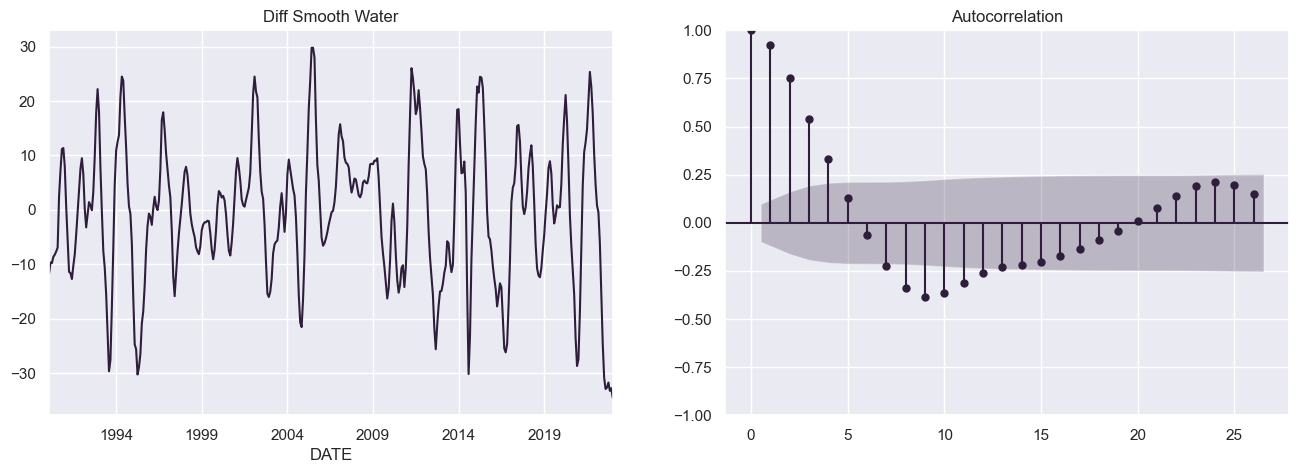

In [53]:
stationarityPlots(smoothGas.diff()[1:],"Diff Smooth Gas")
stationarityPlots(smoothWater.diff()[1:],"Diff Smooth Water")

More stationary now

### ARIMA Order

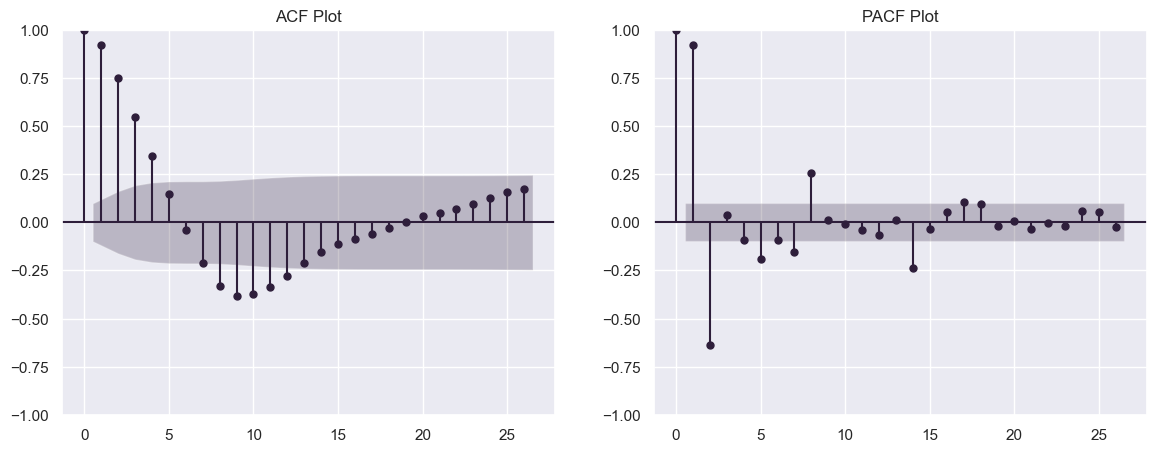

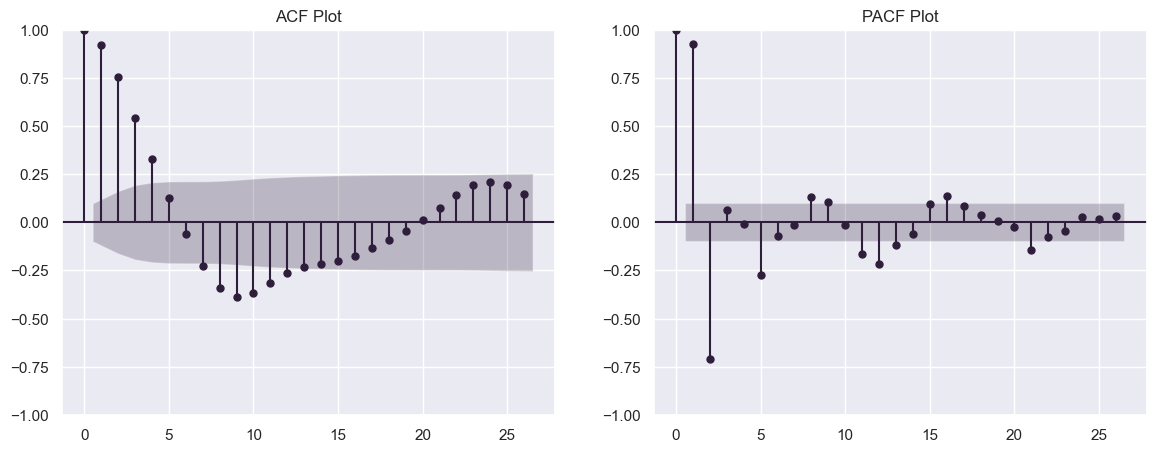

In [54]:
acfPacf(smoothGas.diff()[1:])
acfPacf(smoothWater.diff()[1:])

#### Gas

| Process      | Requirement                                             | Plot Name                    | Lag Selection                 | Chosen Value |
|--------------|---------------------------------------------------------|------------------------------|-------------------------------|--------------|
| AR           | Specify \( p \) terms for future value prediction      | PACF Plot                    | Lag 1,2 and then drops to 0              | 2            |
| MA           | Specify \( q \) terms for autocorrelation removal      | ACF Plot                     | Lag at 1,2,3,4                      | 4            |

Order = (2, 1, 4)

#### Water

| Process      | Requirement                                             | Plot Name                    | Lag Selection                 | Chosen Value |
|--------------|---------------------------------------------------------|------------------------------|-------------------------------|--------------|
| AR           | Specify \( p \) terms for future value prediction      | PACF Plot                    | Lag 1,2,5 and then drops to 0              | 5            |
| MA           | Specify \( q \) terms for autocorrelation removal      | ACF Plot                     | Lag at 1,2,3,4 and maybe 5                     | 5            |


Order = (5, 1, 5)

### Model

In [55]:
arima = ARIMA(endog=smoothGas,order=(2, 1, 4)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  397
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 273.850
Date:                Fri, 11 Aug 2023   AIC                           -533.700
Time:                        20:20:14   BIC                           -505.830
Sample:                    01-01-1990   HQIC                          -522.659
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7286      0.058     30.033      0.000       1.616       1.841
ar.L2         -0.8318      0.049    -16.999      0.000      -0.928      -0.736
ma.L1         -0.0639      0.054     -1.174      0.240      -0.170       0.043
ma.L2         -0.3711      0.060     -6.229      0.000      -0.488      -0.254
ma.L3         -0.0907      0.047     -1.938      0.053      -0.182       0.001
ma.L4          0.2565      0.040      6.378      0.000       0.178       0.335
sigma2         0.0145      0.001     28.913      0.000       0.014       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              2420.27
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

No removing needed.

In [56]:
arima = ARIMA(endog=smoothWater,order=(5, 1, 5)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  397
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -924.974
Date:                Fri, 11 Aug 2023   AIC                           1871.949
Time:                        20:20:15   BIC                           1915.744
Sample:                    01-01-1990   HQIC                          1889.299
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0571      0.205     10.044      0.000       1.656       2.458
ar.L2         -1.6257      0.519     -3.130      0.002      -2.644      -0.608
ar.L3          0.0581      0.617      0.094      0.925      -1.151       1.267
ar.L4          0.8260      0.397      2.080      0.038       0.048       1.604
ar.L5         -0.4762      0.119     -4.013      0.000      -0.709      -0.244
ma.L1         -0.1849      0.203     -0.911      0.362      -0.583       0.213
ma.L2          0.0296      0.134      0.221      0.825      -0.233       0.292
ma.L3          0.3895      0.121      3.222      0.001       0.153       0.627
ma.L4          0.3641      0.055      6.589      0.000       0.256       0.472
ma.L5         -0.0302      0.103     -0.292      0.770      -0.233       0.172
sigma2         6.1683      0.356     17.332      0.000       5.471       6.866
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                56.40
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

I will set q=4 as the 5th predictor doesn't contribute much

In [57]:
def newCrossVal(df,second, test_splits, test_size, models,**kwargs):
    scores = []
    tscv = TimeSeriesSplit(n_splits=test_splits, test_size=test_size)
    for train_index, test_index in tscv.split(df):
        train_data = second.iloc[train_index]
        test_data = df.iloc[test_index]
        model_inst = models(train_data,**kwargs)
        model_fit = model_inst.fit()
        y_pred = model_fit.forecast(len(test_data))
        score = mean_absolute_percentage_error(test_data, y_pred)
        scores.append(score)
    return np.mean(scores)

Cross Validation Score (MAPE): 0.1693327339167513


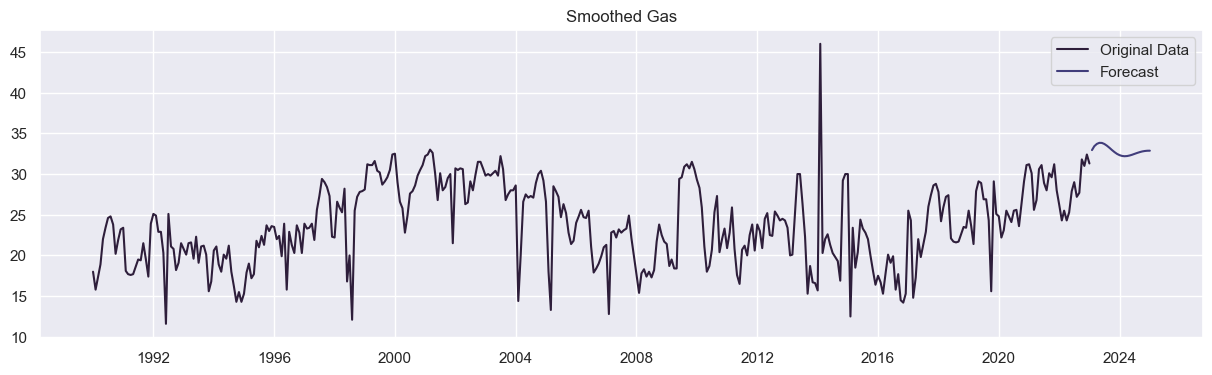

In [58]:
arima = ARIMA(endog=smoothGas,order=(2, 1, 4)).fit()
forecast_values = arima.forecast(steps=24)
mape_score = newCrossVal(gas,smoothGas,5,24,ARIMA, 
                           order=(2, 1, 4))
plotForecast(gas,forecast_values,"Smoothed Gas",mape_score)

Insights:
- MAPE has improved from 19% to 16%
- Curve is smooth but accuracy is fine



Cross Validation Score (MAPE): 0.2867366946531381


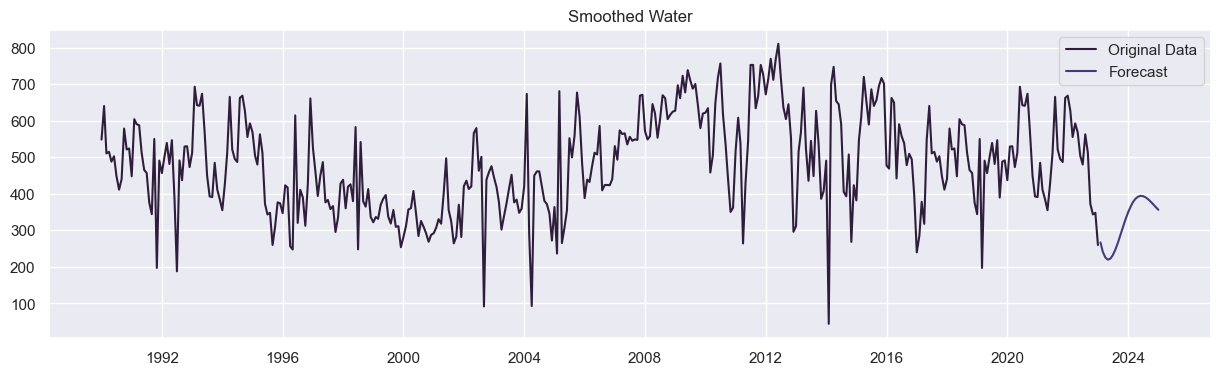

In [59]:
arima = ARIMA(endog=smoothWater,order=(5, 1, 4)).fit()
forecast_values = arima.forecast(steps=24)
mape_score = newCrossVal(water,smoothWater,5,24,ARIMA, 
                           order=(5, 1, 4))
plotForecast(water,forecast_values,"Smoothed Water",mape_score)

Insights:
- MAPE has improved from 30% to 28%
- Curve is smooth but accuracy is fine

## Final Evaluation

So far we used 2 years as our forecast horizon but it might be too long for some models to predict accurately. Therefore it is important to set the forecast horizon based on decline in accuracy (elbow method)

I will plot accuracy against the forecast horizon.

In [60]:
def forecastHorizon(df,models,**kwargs):
    sizes = np.arange(6,54,6)
    accuracy = []
    for i in sizes:        
        score = crossVal(df,5,i,models,**kwargs)
        accuracy.append(score)
    return accuracy,sizes
def newForecastHorizon(df,second,models,**kwargs):
    sizes = np.arange(6,54,6)
    accuracy = []
    for i in sizes:        
        score = newCrossVal(df,second,5,i,models,**kwargs)
        accuracy.append(score)
    return accuracy,sizes

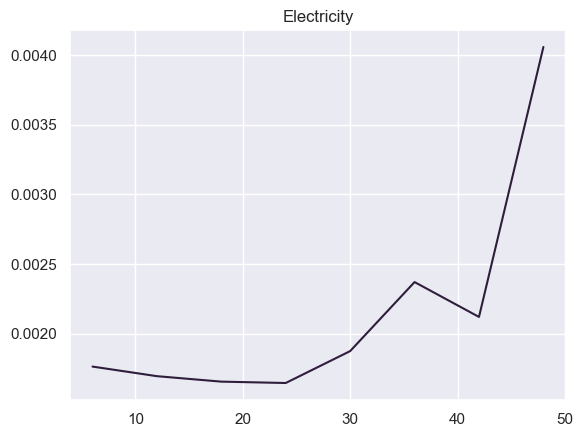

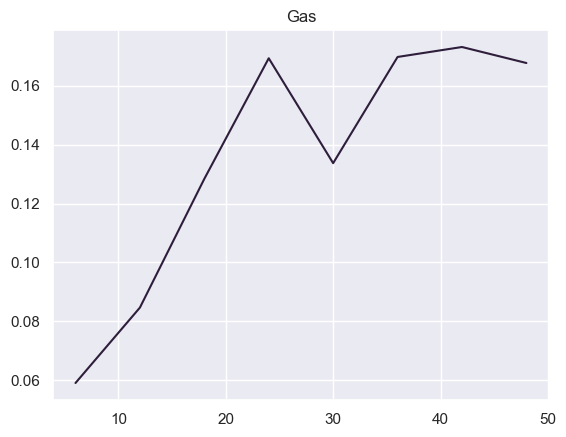

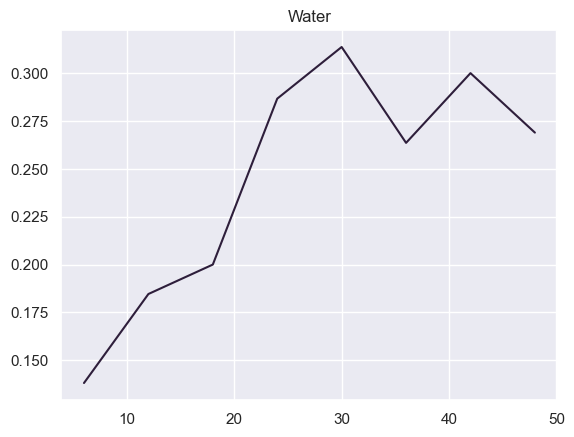

In [61]:
acc,size = forecastHorizon(cox_elec,ARIMA,order=(1,0,2),seasonal_order=(2,1,1,12))
sns.lineplot(x=size,y=acc)
plt.title("Electricity")
plt.show()

acc,size = newForecastHorizon(gas,smoothGas,ARIMA, 
                           order=(2,1,4))
sns.lineplot(x=size,y=acc)
plt.title("Gas")
plt.show()

acc,size = newForecastHorizon(water,smoothWater,ARIMA, 
                           order=(5,1,4))
sns.lineplot(x=size,y=acc)
plt.title("Water")
plt.show()

Insights:
- Electricity is very accurate and this it can forecast up to 42 points (3.5 years) while maintaining good accuracy
- Gas can only forecast 6 points to be accuract
- Water can only forecast 6 points and still be slightly acceptable.

gas MAPE Score: 0.05946750526738972
electricity MAPE Score: 0.0018224386267699966
water MAPE Score: 0.12697590652492044


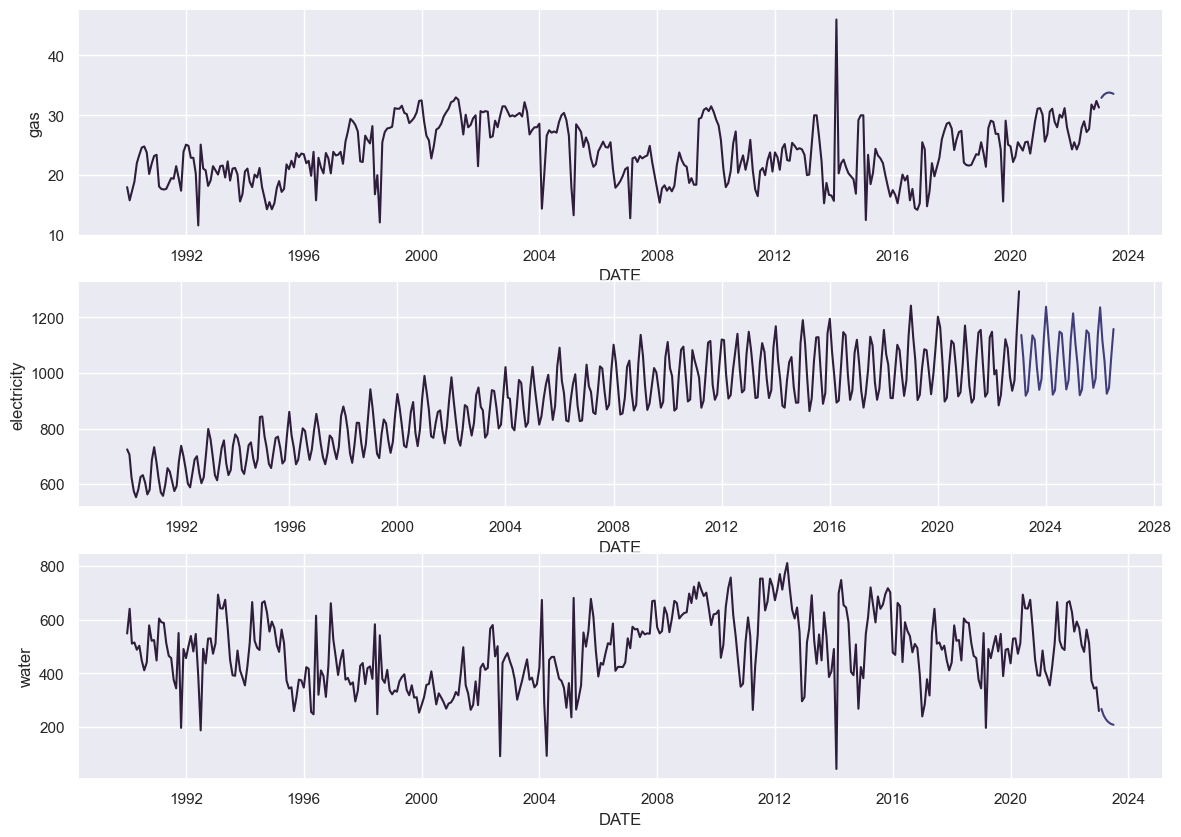

In [62]:
mapes = []
forecasts = []
# Gas
arima = ARIMA(endog=smoothGas,order=(5,1,5)).fit()
forecasts.append(arima.forecast(steps=6))
mapes.append(newCrossVal(gas,smoothGas,5,6,ARIMA, 
                           order=(5,1,5)))

# Electricity
arima = ARIMA(endog=cox_elec,order=(0,1,4),
              seasonal_order=(2,1,1,12)).fit()
forecast_vals = arima.forecast(steps=42)
forecasts.append(pd.Series(data=inv_boxcox(forecast_vals,-0.2),index=forecast_vals.index) )
 
mapes.append(crossVal(cox_elec,5,42,ARIMA, 
                           order=(0,1,4), seasonal_order=(2,1,1,12)))

# Water
arima = ARIMA(endog=smoothWater,order=(4,1,5)).fit()
forecasts.append(arima.forecast(steps=6))
mapes.append(newCrossVal(water,smoothWater,6,6,ARIMA, 
                           order=(4,1,5)))

fig,ax = plt.subplots(3,1,figsize=(14,10))
for i in range(0,3):
    print(f"{df.columns[i]} MAPE Score: {mapes[i]}")
    sns.lineplot(x=df.index,y=df[df.columns[i]],ax=ax[i])
    sns.lineplot(x=forecasts[i].index,y=forecasts[i].values,ax=ax[i])

fig.show()

These are the final forecasts. 

Summary:

| Time Series | Forecast Duration | MAPE (%) | Forecast Ability | Notes |
|-------------|-------------------|----------|------------------|-------|
| Electricity | 3.5 years        | 0.18     | Excellent        | Very accurate for medium to long term forecasts due to clean data, strong trend, and seasonality. |
| Gas         | 6 months         | 5.95     | Acceptable       | Hard to predict due to noise, lacks strong trend or seasonality. Acceptably accurate for short term forecasts. |
| Water       | 6 months         | 12.70    | Limited          | Extremely difficult to model due to high noise. Not very accurate, suitable only for short term forecasts with caution. |